# Financial Econometrics I  
# Project: Volatility Forecasting

**<span style='background: lightblue'>Group Number: 22;    
Assigned Asset: 12.</span>**  
  
Team Member:  
Lin Zhang : 15845542@fsv.cuni.cz  
Weiwei Qu : 51014941@fsv.cuni.cz

# Part 1. Data description

### Provide short summary of descriptive statistics, ACF plots and plots of data you are going to use.

* **Setup environment**

In [90]:
# Setup environment
Sys.setenv(LANG = "en")
Sys.setlocale("LC_TIME", "English")
version[['version.string']]
options(warn = -1)  # suppressing warnings
options(repr.plot.width = 7, repr.plot.height = 6)

# Load library
if (!require(rugarch)) install.packages('rugarch')
if (!require(repr)) install.packages('repr')
if (!require(aTSA)) install.packages('aTSA')
if (!require(quantmod)) install.packages('quantmod')
if (!require(forecast)) install.packages('forecast')
if (!require(highfrequency)) install.packages('highfrequency')
if (!require(fGarch)) install.packages('fGarch')
if (!require(tseries)) install.packages('tseries')
if (!require(ggplot2)) install.packages('ggplot2')
if (!require(ggthemes)) install.packages('ggthemes')

library(rugarch)
library(repr)
library(aTSA)
library(quantmod)
library(forecast)
library(highfrequency)
library(fGarch)
library(tseries)
library(ggplot2)
library(ggthemes) 

[1] "English_United States.1252"

[1] "R version 4.1.2 (2021-11-01)"

In [2]:
# Load to continue ...
# save.image(file = "FE_project.RData")
# load("FE_project.RData")
# print("Welcome back!")

**This homework is coded in environment of R version 4.1.2, please note that running the code on different R version might get slightly different results.   
"Restart & Run ALL" code would take about <span style='background: lightblue'>40 minutes</span>. (R_GARCH forecast itself would take 36 minutes)**  

###  (1). Load Data Set

Each ".RData" file contains an xts file with
* returns (ret),
* realized volatility (RV),
* positive realized semi-volatility (RV p),
* negative realized semi-volatility (RV n),
* realized skewness (RS),
* realized kurtosis (RK).

In [3]:
# load assigned asset data number 12
load("12.RData")
ls()
nrow(adp)
head(adp, 2)
tail(adp, 2)
rets <- adp$ret
RV_day <- adp$RV
RV_p <- adp$RV_p
RV_n <- adp$RV_n
RV_RS <- adp$RS
RV_RK <- adp$RK


[1] "adp"

[1] 1500

                   ret          RV        RV_p        RV_n        RS       RK
2010-01-05 -0.02065318 0.007350539 0.005405043 0.004981559 0.1417402 4.466892
2010-01-06  0.00351129 0.007256418 0.005266342 0.004992118 0.3714606 4.651872

                   ret         RV        RV_p        RV_n         RS       RK
2016-01-21 0.007654638 0.01692255 0.011953961 0.011978127 -0.1390421 3.147117
2016-01-22 0.026832732 0.01078354 0.008042433 0.007183591  0.3585356 3.632521

**By observing, this data set contains 1500 daily samples from 2010-2016, each year has 250 trading days, so this is about 6 years data.  
Since we only received the Realized Volatility sample data directly from data source, without the detailed intraday trading prices available. So for some parts, we could only discuss the theory of possible caveats tied to the nature of high-frequency data, such as overnight returns may cause the difference between Return and RV sample data, and possibly affect GARCH type models forecasting results.**

###  (2). Analysis Returns

* **Observe the plot**

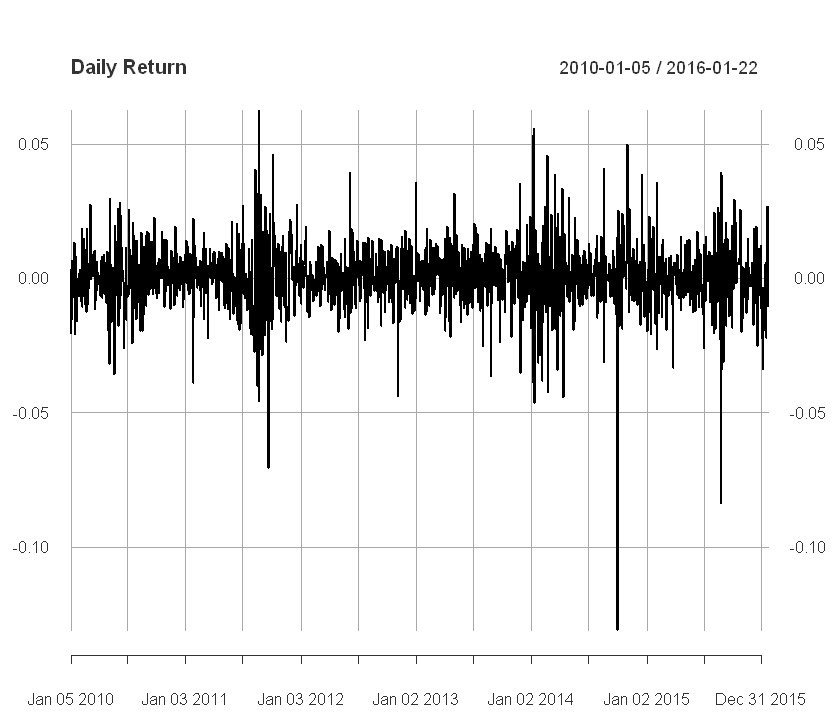

In [4]:
# set up plot parameters
c_col2 <- c("black", "red")
c_col3 <- c("black","red", "blue")
c_col4 <- c("black","red", "blue", "green")
r_col <- rainbow(6)

options(repr.plot.width = 7, repr.plot.height = 6)
plot(rets,  xlab = 'Year', ylab = NA, main = 'Daily Return', 
     axes = F, cex.main = 0.8)

**From the plot we could observe that the Mean of Returns is probably zero, clearly AutoCorrelation exists, and it seems stationary. No obvious shifting is observed, so should no need for sub-sampling.  
We observe that several spikes of return in 2011 summer bring much higher volatility, shows volatility clustering after. Also on spring of 2014, there are high volatility and persisit cluster again. The biggest spikes happen at 2014 Fall and 2015 Fall.**

* **ACF and PACF test for lags depenency.**

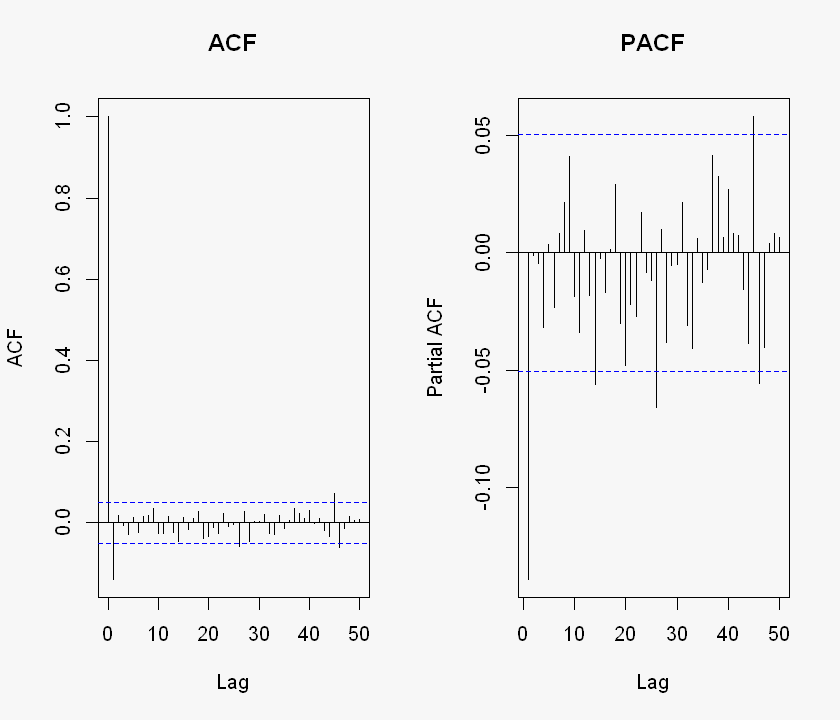

In [5]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)
par(mfrow = c(1, 2))
acf(rets, main =  'ACF', lag = 50)
pacf(rets, main = 'PACF', lag = 50)

**From ACF and PACF test, there seems a lot of dependence visible especially at lag 1 and 2.    
And we could not rule out stationarity based on ACF and PACF, still need to conduct formal tests for autocorrelation and stationarity.**

* **Apply DF and KPSS test for Stationarity.**

In [6]:
adf.test(rets)
kpss.test(rets, null = 'Level')
kpss.test(rets, null = 'Trend')


	Augmented Dickey-Fuller Test

data:  rets
Dickey-Fuller = -11.293, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary



	KPSS Test for Level Stationarity

data:  rets
KPSS Level = 0.059634, Truncation lag parameter = 7, p-value = 0.1



	KPSS Test for Trend Stationarity

data:  rets
KPSS Trend = 0.043563, Truncation lag parameter = 7, p-value = 0.1


**In Augmented Dickey-Fuller(DF) Test, p-value results = 0.01, so we could reject non-stationarity, and conclude that this time series is stationary.  
In Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test, p-value results = 0.1, so we fail to reject the null hypothesis of the time series is trend stationary, and conclude that it is stationary.**

* **Apply Ljun-Box test for AutoCorrelation.**

In [7]:
Box.test(rets, type = 'Ljung-Box')
Box.test(rets, lag = 2, type = 'Ljung-Box')


	Box-Ljung test

data:  rets
X-squared = 29.131, df = 1, p-value = 6.763e-08



	Box-Ljung test

data:  rets
X-squared = 29.644, df = 2, p-value = 3.654e-07


**As we expected, since both Box-Ljung test for 1 lag and 2 lags have p_value < 0.01.   
Becasue null Hypothes H0 is residuals are independently distributed(no correlation). So as p-value is smaller than 0.01, we can reject the null hypothesis, which means this time series has autocorrelation.**

###  (3). Analysis Realized Volatility

* **ACF and PACF test**

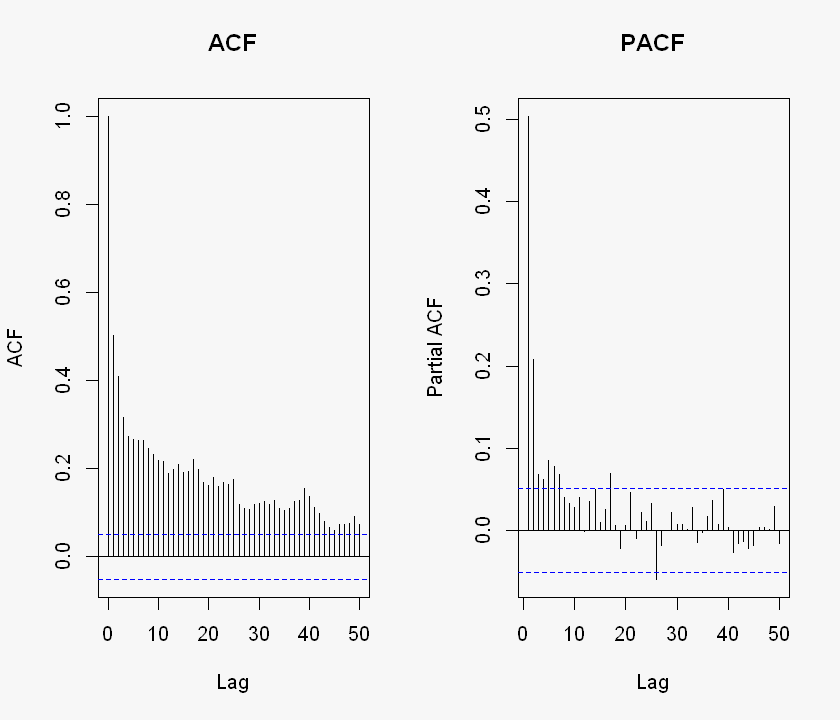

In [8]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)
par(mfrow = c(1, 2))
acf(RV_day, main =  'ACF', lag = 50)
pacf(RV_day, main = 'PACF', lag = 50)

**From ACF and PACF test, clearly there are a lot of dependencies in RV samples. All lags are significant, it meets our expectation of Volatility has long memory.**

* **DF and KPSS test for Stationarity.**

In [9]:
adf.test(RV_day)
kpss.test(RV_day, null = 'Level')
kpss.test(RV_day, null = 'Trend')


	Augmented Dickey-Fuller Test

data:  RV_day
Dickey-Fuller = -6.5141, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary



	KPSS Test for Level Stationarity

data:  RV_day
KPSS Level = 1.3795, Truncation lag parameter = 7, p-value = 0.01



	KPSS Test for Trend Stationarity

data:  RV_day
KPSS Trend = 0.85419, Truncation lag parameter = 7, p-value = 0.01


**In DF Test, p-value results = 0.01, so we could reject non-stationarity, and conclude that this time series is stationary.  
In KPSS Test, p-value results = 0.1, so we fail to reject the null hypothesis of the time series is trend stationary, and conclude that it is stationary.**

* **Apply Ljun-Box test for AutoCorrelation.**

In [10]:
Box.test(RV_day, type = 'Ljung-Box')
Box.test(RV_day, lag = 2, type = 'Ljung-Box')
Box.test(RV_day, lag = 5, type = 'Ljung-Box')
Box.test(RV_day, lag = 8, type = 'Ljung-Box')


	Box-Ljung test

data:  RV_day
X-squared = 380.61, df = 1, p-value < 2.2e-16



	Box-Ljung test

data:  RV_day
X-squared = 631.98, df = 2, p-value < 2.2e-16



	Box-Ljung test

data:  RV_day
X-squared = 1003.4, df = 5, p-value < 2.2e-16



	Box-Ljung test

data:  RV_day
X-squared = 1306.4, df = 8, p-value < 2.2e-16


**All BL test have p_value < 0.01, so this RV time series has autocorrelation.**

* **Observe the plot**

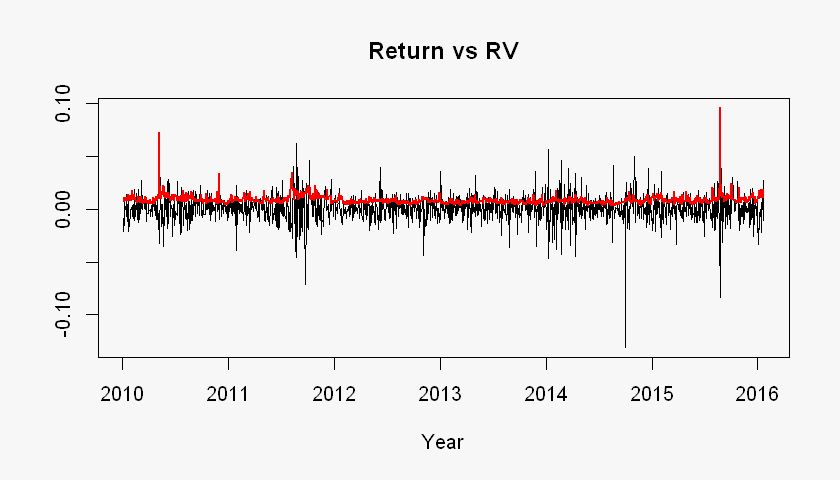

In [11]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

y_scale <- range(c(rets, RV_day))

plot.zoo(rets, xlab='Year', ylab=NA, ylim = y_scale,
         main= "Return vs RV" )
lines(zoo(RV_day),col="red", lwd=2)


**By observing, Realized Volatility almost matches the volaitility of Returns. But some spike of return data in 2014 is filtered out(not reflected in RV), probably due to overnight Variance is not included in RV.  
Especially some high volatiltiy in 2014 Return samples are missed in RV data, <span style='background: lightblue'>this would cause the forecasting results from GARCH type methoeds different from RV "True" value.</span>**

**Next step we check those special sample data points of valatility spikes.**

In [12]:
apply(adp, 2, range)

ret,RV,RV_p,RV_n,RS,RK
-0.13123655,0.003333799,0.001701334,0.001677954,-8.113845,2.153265
0.06243346,0.095667302,0.093195619,0.059515450,6.622022,69.697628


* **Check Jumps**

In [13]:
max(abs(rets))
print("Max Return index:")
spike_return <- which.max(abs(rets))
spike_return
print("Max Return date:")
index(rets)[spike_return]

print("Highest valatility in Returns sample:") 
rets[which.max(abs(rets))]
rets['2014-09-29/2014-10-03']
RV_day['2014-09-29/2014-10-03']

[1] 0.1312365

[1] "Max Return index:"


[1] 1181

[1] "Max Return date:"


[1] "2014-10-01"

[1] "Highest valatility in Returns sample:"


                  ret
2014-10-01 -0.1312365

                   ret
2014-09-29 -0.00316410
2014-09-30  0.01547800
2014-10-01 -0.13123655
2014-10-02 -0.01906125
2014-10-03  0.02547050

                    RV
2014-09-29 0.006583747
2014-09-30 0.007968604
2014-10-01 0.009093024
2014-10-02 0.010512395
2014-10-03 0.009403582

**On <span style='background: lightblue'>2014-10-01</span> the sample data has highest volatility in Returns as -13%, but in RV data this volatility is not reflected.**

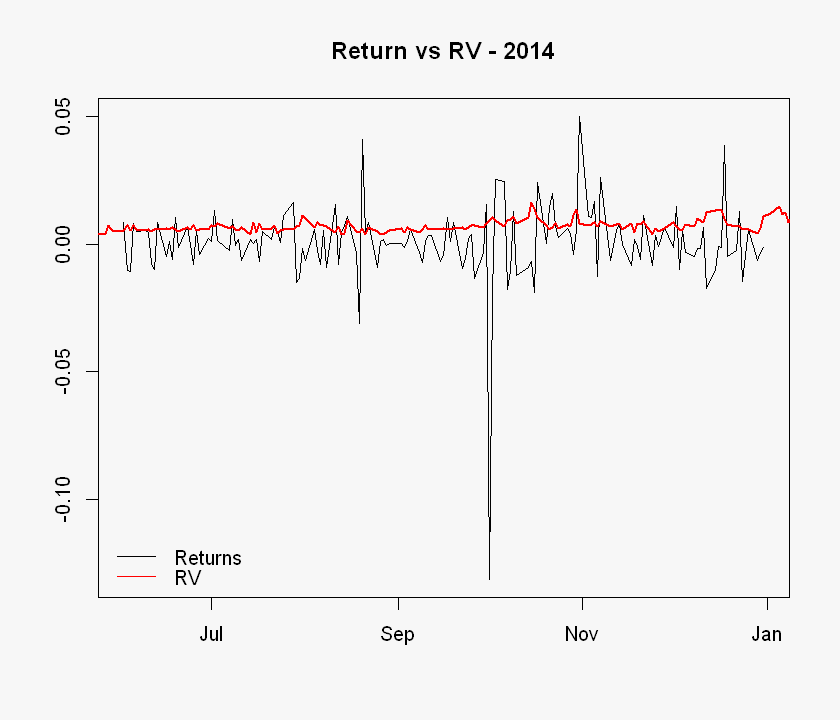

In [14]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)

d_range <- '2014-06/2014-12'
plot.zoo(rets[d_range], xlab=NA, ylab=NA, 
         main= "Return vs RV - 2014" )
lines(zoo(RV_day),col="red", lwd=2)
legend("bottomleft", legend = c("Returns", "RV"), 
       col = c_col2, lwd = 1, bty="n")

**Some extreme values are truncated, for example the spike of return in 2014-10-01 is filtered out, it could be the result of Winsorization or Truncation for extreme values.   
Another explaination is the result of comparing open-to-close variance (realized measures of volatility) with close-to-close variance (Returns, which GARCH model uses).**

* **Check Maximum RV data**

In [15]:
print("Max RV index:")
spike <- which.max(RV_day)
spike
print("Max RV date:")
index(RV_day)[spike]
rets['2015-08-20/2015-08-26']
RV_day['2015-08-20/2015-08-26']

[1] "Max RV index:"


[1] 1404

[1] "Max RV date:"


[1] "2015-08-24"

                    ret
2015-08-20 -0.008090397
2015-08-21 -0.022591471
2015-08-24 -0.083950519
2015-08-25  0.039348533
2015-08-26 -0.034311869

                   RV
2015-08-20 0.01178037
2015-08-21 0.01968633
2015-08-24 0.09566730
2015-08-25 0.02410682
2015-08-26 0.02410816

**On <span style='background: lightblue'>2015-08-24</span> the stock has highest Daily Realized Volatility at 9.6%, while the absolute return value of that day 8.39% is also at least 4 times higher than usual. So in this case, RV data matched the volatility of return at the spike point.  
We will use this sample data spike on RV on 2015-08-24 as a checking point in model forecast verification part.**

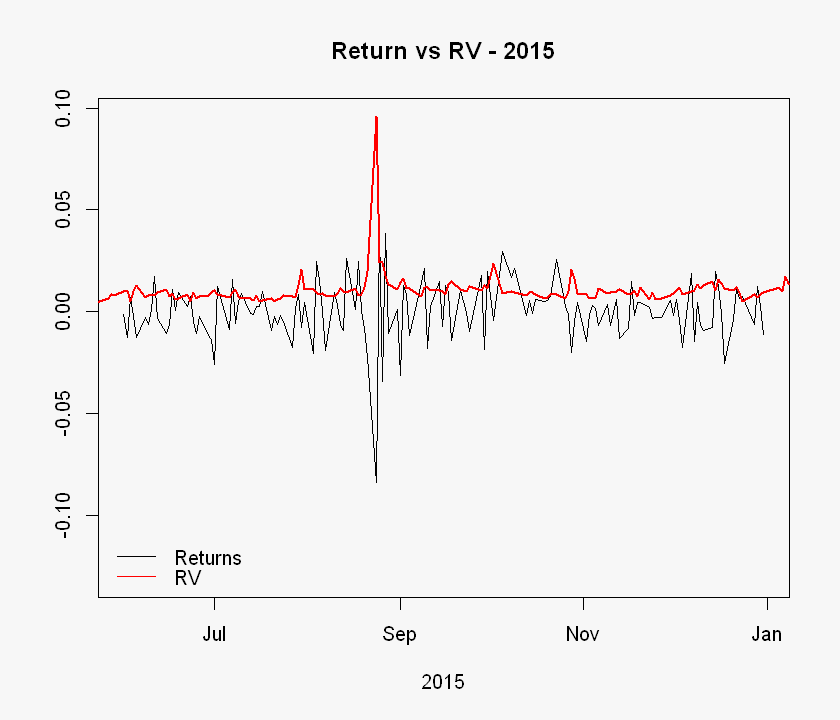

In [16]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)
y_scale <- range(c(rets[d_range], RV_day))

d_range <- '2015-06/2015-12'
plot.zoo(rets[d_range], xlab='2015', ylab=NA, 
         ylim = y_scale,main= "Return vs RV - 2015")
lines(zoo(RV_day),col="red", lwd=2)
legend("bottomleft", legend = c("Returns", "RV"), 
       col = c_col2, lwd = 1, bty="n")


###  (4). Analysis Asymmetry of Realized Volatility

* **Analysis Positive and Negative realized semi-volatility data**

[1] 0.09319562

[1] "2015-08-24"

[1] 0.05951545

[1] "2010-05-06"

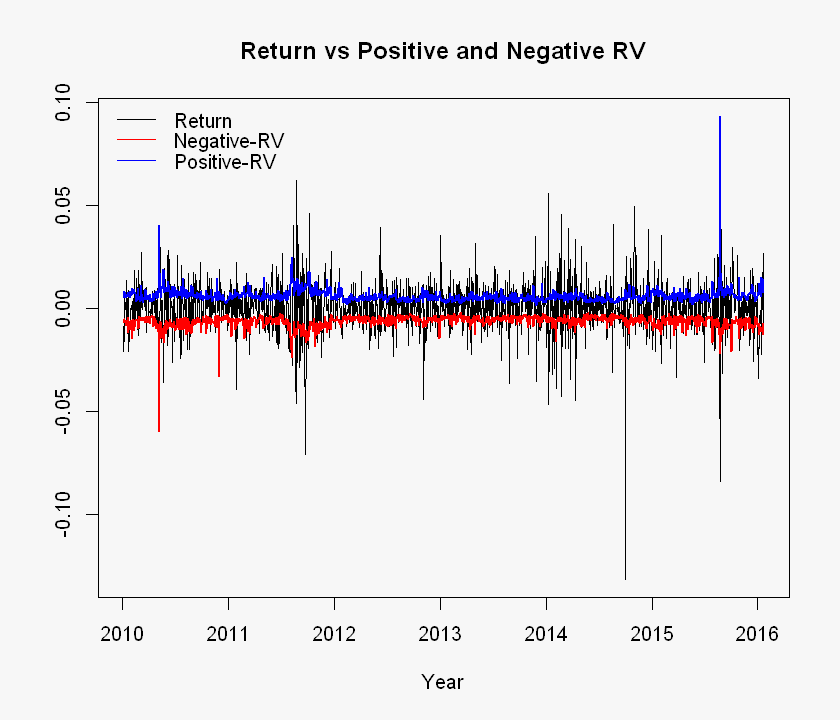

In [17]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)

y_scale <- range(c(rets, RV_p, -RV_n))
plot.zoo(rets, xlab='Year', ylab=NA, ylim = y_scale, 
    main= "Return vs Positive and Negative RV")

lines(-zoo(RV_n), col = c_col3[2], lwd=2)
lines(zoo(RV_p), col = c_col3[3], lwd=2)
legend("topleft", col = c_col3, lwd = 1, bty="n",
      legend = c("Return",  "Negative-RV", "Positive-RV"))

# Check the max value dates
max(RV_p)
index(RV_p)[which.max(RV_p)]
max(RV_n)
index(RV_n)[which.max(RV_n)]

**In this plot, Negative Voalitily is showed in negative absolute value in red. By observing, Negative RV seems higher than Positive RV, proved the asymmetries of volatility.  
Since the maximum Negative RV happens in 2010 spring, so we zoom in for a better look.**

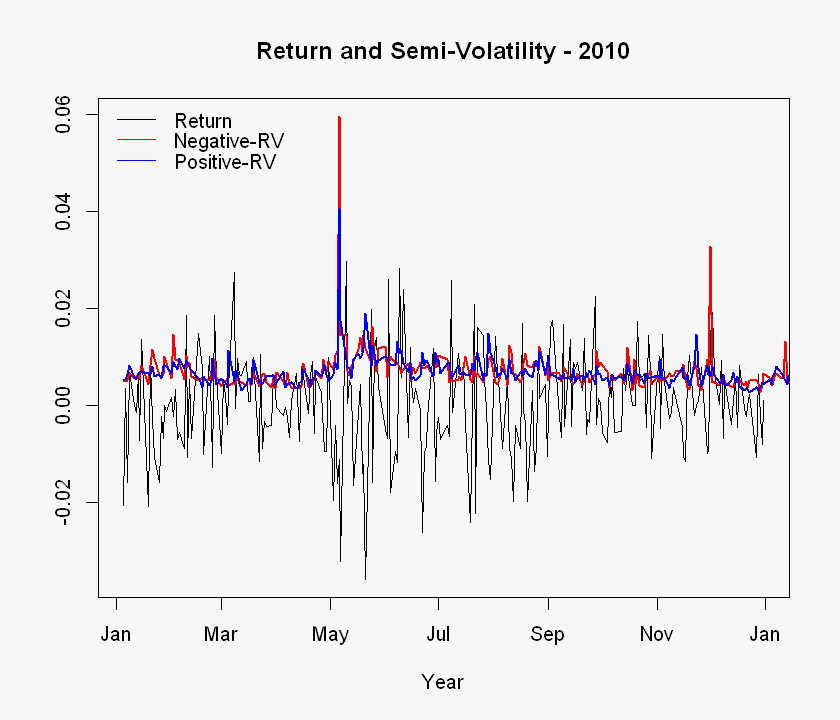

In [18]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)

d_range <- '2010'

y_scale <- range(c(rets[d_range],RV_n[d_range]))
plot.zoo(rets[d_range], xlab='Year', ylab=NA, ylim = y_scale, 
    main= "Return and Semi-Volatility - 2010")

lines(zoo(RV_n), col = c_col3[2], lwd=2)
lines(zoo(RV_p), col = c_col3[3], lwd=2)
legend("topleft", col = c_col3, lwd = 1, bty="n",
      legend = c("Return",  "Negative-RV", "Positive-RV"))


**Now we could clearly see Negative Realized Semi-Volatility has harger impact on future volatility，bad news usually bring negative returs and higher volatilities after.**

* **ACF Analysis of Positive and Negative realized semi-volatility**

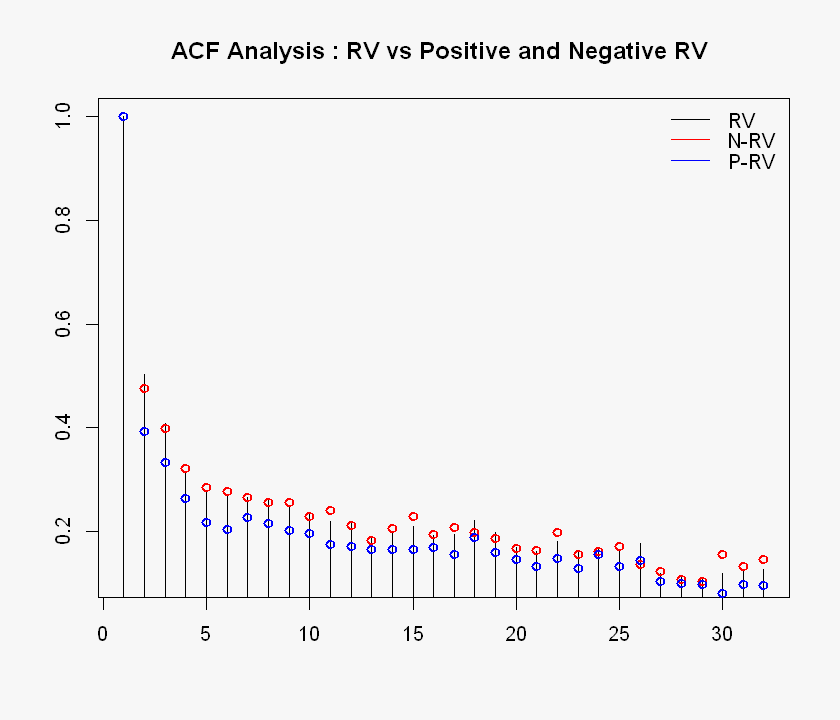

In [19]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)

acf_RV <- acf(RV_day, plot = FALSE)$acf[,1,1]
acf_up <- acf(RV_p, plot = FALSE)$acf[,1,1]
acf_down <- acf(RV_n, plot = FALSE)$acf[,1,1]

plot(acf_RV, type = "h", ylab = NA, xlab = NA, 
     main= "ACF Analysis : RV vs Positive and Negative RV ")
points(acf_down,col = c_col3[2], lwd=2)
points(acf_up,col = c_col3[3], lwd=2)
legend("topright", col = c_col3, lwd = 1, bty="n",
      legend = c("RV", "N-RV", "P-RV"))

**By observe ACF chart, we find Positive RV and Negative RV provide different information.   
Start from scecond lag, the difference between positive and negative realized volatility are very difference. Clearly,  negative RV has the higher influence on volatility, which drives the total RV results.**

###  (5). Plot Higher order Realized Monments

* **Realized Skewness**

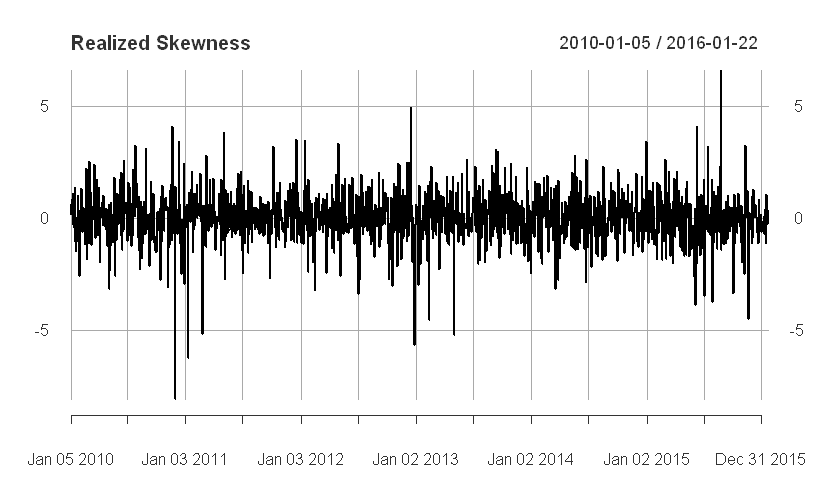

In [20]:
options(repr.plot.width = 7, repr.plot.height = 4)
plot(RV_RS,  xlab = 'Year', ylab = NA, axes = F, 
     cex.main = 0.8, main = 'Realized Skewness' )

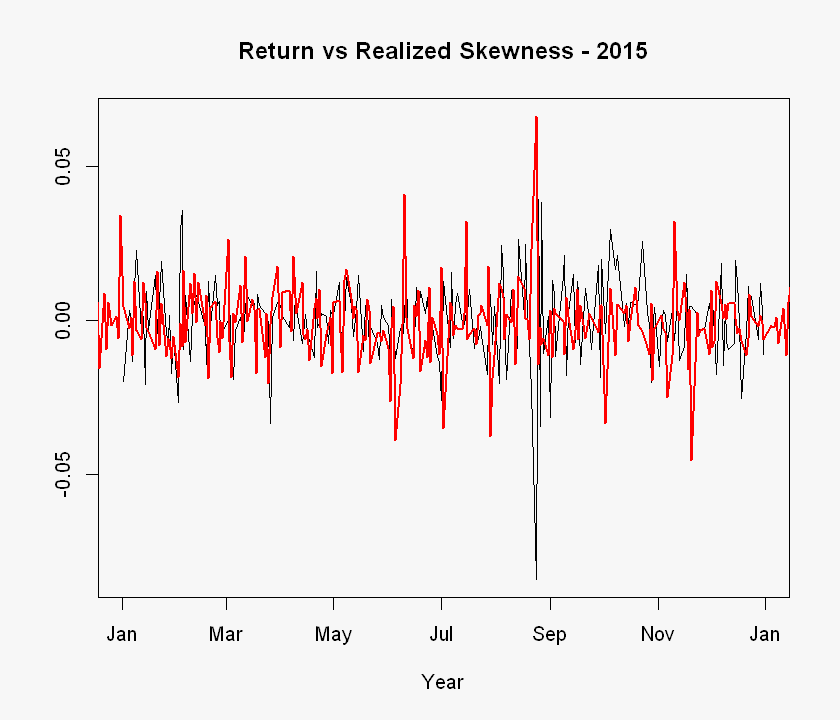

In [21]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)
d_range <- '2015'
RS_plot <- RV_RS/100
y_scale <- range(c(rets[d_range],RS_plot[d_range]))
plot.zoo(rets[d_range], xlab='Year', ylab=NA, ylim = y_scale, 
   main= "Return vs Realized Skewness - 2015")
lines(zoo(RS_plot), col = "red", lwd=2)

**From this zoom in view at 2015 period, we could see Realized Skewness mostly just captures jump contribution, and positive jumps bring positive skewness, negative jumps bring negative skewness.**

* **Realized Kurtosis**

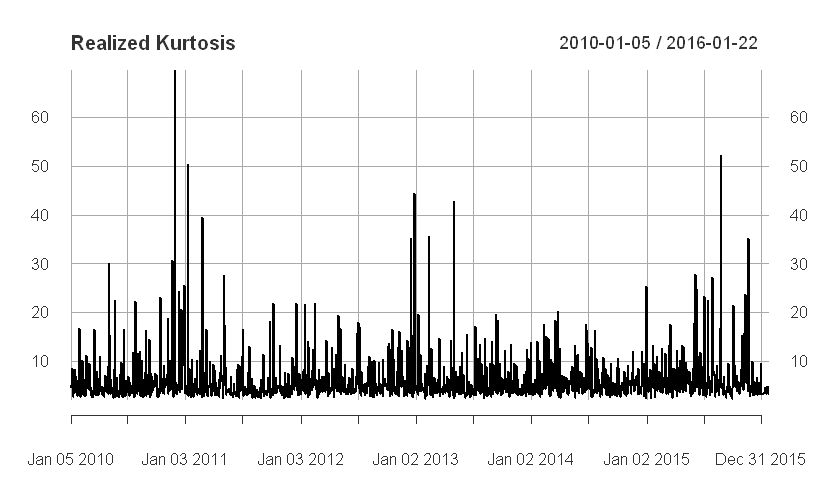

In [22]:
options(repr.plot.width = 7, repr.plot.height = 4)
plot(RV_RK,  xlab = 'Year', ylab = NA, axes = F, 
     cex.main = 0.8, main = 'Realized Kurtosis')

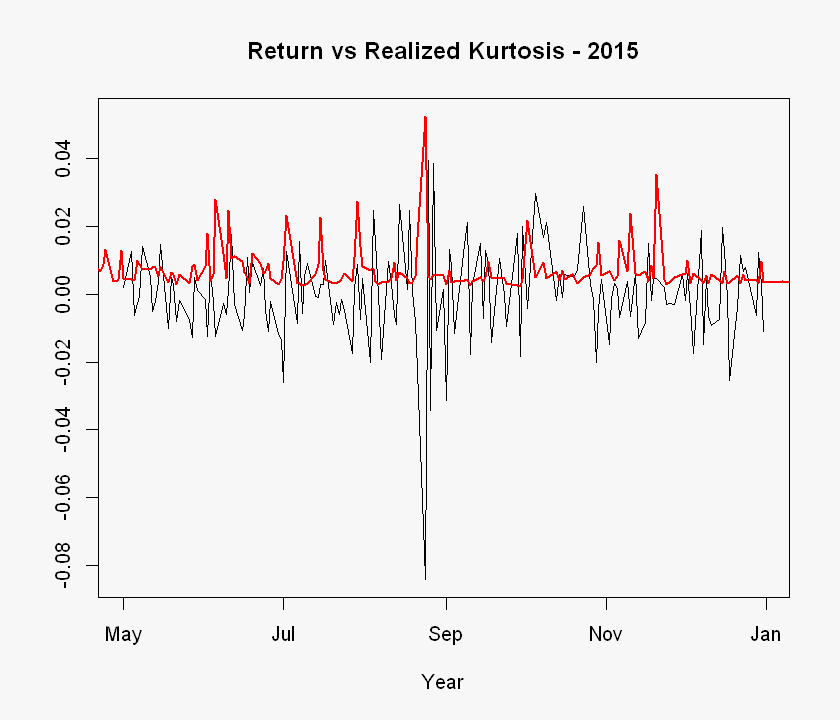

In [23]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)
d_range <- '2015-05/2015-12'
RK_plot <- RV_RK/1000
y_scale <- range(c(rets[d_range],RK_plot[d_range]))
plot.zoo(rets[d_range], xlab='Year', ylab=NA, ylim = y_scale, 
   main= "Return vs Realized Kurtosis - 2015")
lines(zoo(RK_plot), col = "red", lwd=2)

**From this zoom in view at 2015 period, we could see Realized Kurtosis could show how fast the volatility changes, meaning Kurtosis could capture the information of Volatility of Volatility.**

# Part 2. In-sample fit

### Estimate parameters of the following volatility models with full sample size: AR(1)-RV, HAR, HAR-RS, HAR-Rskew-RKurt, Realized GARCH, ARMA-GARCH. Discuss the fits and compare qualitative differences of the estimates shortly. Note you can simply use the plot comparing in-sample fits of all models.

###  (1). AR(1)-RV

**Estimate AR(1):**   
$$RV_{t+1} = \phi_0 + \phi_1 RV_{t}$$  
**RV as Realized Volatility.**

* **Call lm function for estimation**

In [24]:
TT <- length(RV_day)
AR1_fit_lm <- lm(RV_day[2:TT] ~ RV_day[1:(TT - 1)] )
AR1_fit_lm


Call:
lm(formula = RV_day[2:TT] ~ RV_day[1:(TT - 1)])

Coefficients:
       (Intercept)  RV_day[1:(TT - 1)]  
          0.004412            0.503288  


* **Call arima function for estimation**

In [25]:
AR1_fit <- Arima(RV_day,c(1,0,0))
AR1_fit

Series: RV_day 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.5031  0.0089
s.e.  0.0223  0.0002

sigma^2 = 1.407e-05:  log likelihood = 6250.85
AIC=-12495.71   AICc=-12495.69   BIC=-12479.77

**By using either lm() and arima() we could get AR(1) regression result $ \phi_1 $ as 0.503.  
The difference in intercept result probably due to the different definition of intercept in arima function. In arima intercept means: $ n_t = "intercept" +  \phi_1 *  (n_{t-1}- "intercept")  + residuals$.**

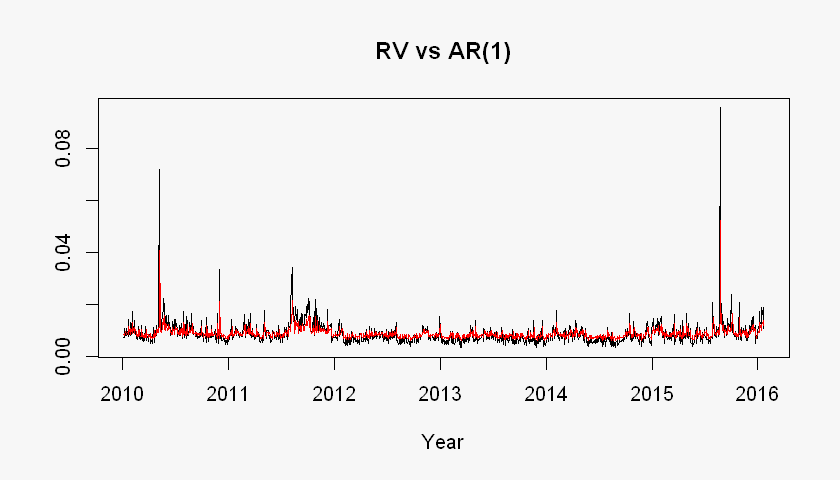

In [26]:
AR1 <- xts(AR1_fit$fitted,order.by = index(RV_day))

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)
plot.zoo(RV_day, xlab='Year', ylab=NA, main= "RV vs AR(1)")
lines(zoo(AR1), col = r_col[1])

###  (2). HAR

**Heterogeneous Autoregressive Model has the form:**

$${RV_t} = \alpha + \beta_1 {RV_{t-1}} + \beta_2 {RV_{t-1}^{(5)}} + \beta_3 {RV_{t-1}^{(22)}} + u_t,$$

**RV as Realized Volatility.**

In [27]:
HAR_fit <- HARmodel(data = RV_day , periods = c(1,5,22), 
    type = "HAR", h = 1, transform = NULL, inputType = "RM")   
HAR_fit


Model:
RV1 = beta0  +  beta1 * RV1 +  beta2 * RV5 +  beta3 * RV22

Coefficients:
   beta0     beta1     beta2     beta3  
0.001624  0.322651  0.193232  0.301570  
Newey-West Standard Errors:
    beta0      beta1      beta2      beta3  
0.0003495  0.0494556  0.0494501  0.0568612  


    r.squared  adj.r.squared  
       0.3036         0.3022  


**Both Beta1 and beta2 at 0.05 level, and R square increased at 30%.**

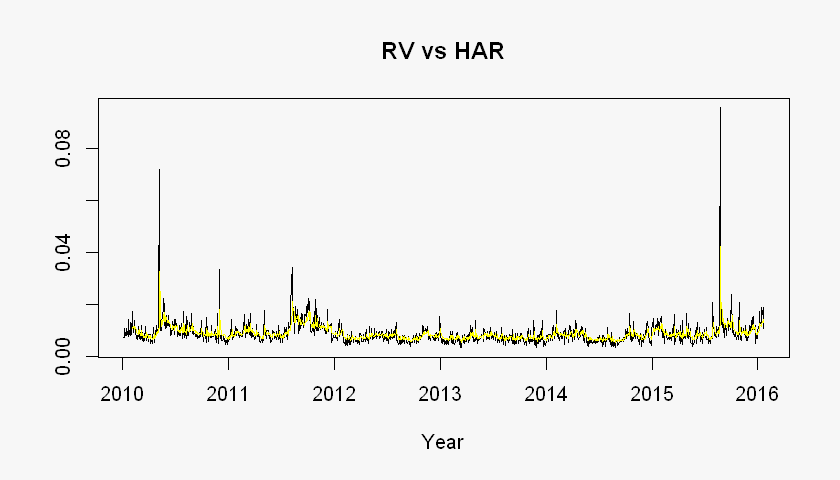

In [28]:
HAR<-xts(HAR_fit$fitted.values,order.by = index(RV_day)[23:TT])

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)
plot.zoo(RV_day, xlab='Year', ylab=NA, main= "RV vs HAR")
lines(zoo(HAR), col = r_col[2])
             

###  (3). HAR-RS

**Decompose $RV$ to $RS^+$, and $RS^-$, Heterogeneous Autoregressive Model with Realized Semivariance has the form:**


$${RV_t} = \alpha + \beta_1 {RS_{t-1}^+} + \beta_2 {RS_{t-1}^-} + \beta_3 {RV_{t-1}^{(5)}} + \beta_4 {RV_{t-1}^{(22)}} + u_t.$$

**RV as Realized Volatility.**

In [29]:
RV5 <- unlist(lapply(lapply(1:(TT - 4), function (t) {
    return(RV_day[t:(t + 4)])}), mean))
RV22 <- unlist(lapply(lapply(1:(TT - 21), function (t) {
    return(RV_day[t:(t + 21)])}), mean))
T5 <- length(RV5)
T22 <- length(RV22)

# included semivariance into HAR model
HAR_RS_fit <- lm(RV_day[23:TT] ~ RV_p[22:(TT - 1)]
    + RV_n[22:(TT - 1)] + RV5[18:(T5 - 1)] + RV22[1:(T22 - 1)])

summary(HAR_RS_fit)


Call:
lm(formula = RV_day[23:TT] ~ RV_p[22:(TT - 1)] + RV_n[22:(TT - 
    1)] + RV5[18:(T5 - 1)] + RV22[1:(T22 - 1)])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.015602 -0.001528 -0.000351  0.000978  0.082013 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.0015343  0.0003562   4.307 1.76e-05 ***
RV_p[22:(TT - 1)] 0.1699647  0.0384369   4.422 1.05e-05 ***
RV_n[22:(TT - 1)] 0.3877729  0.0448387   8.648  < 2e-16 ***
RV5[18:(T5 - 1)]  0.1505427  0.0530561   2.837  0.00461 ** 
RV22[1:(T22 - 1)] 0.2876347  0.0576710   4.988 6.84e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003607 on 1473 degrees of freedom
Multiple R-squared:  0.3169,	Adjusted R-squared:  0.3151 
F-statistic: 170.9 on 4 and 1473 DF,  p-value: < 2.2e-16


**Upside and downside coefficients are not same, impact of downside is bigger as 0.38, upside is only 0.16. So negative semi-volatility has much stronger influcence of values. R squred is a little improved again to 31.5%.**

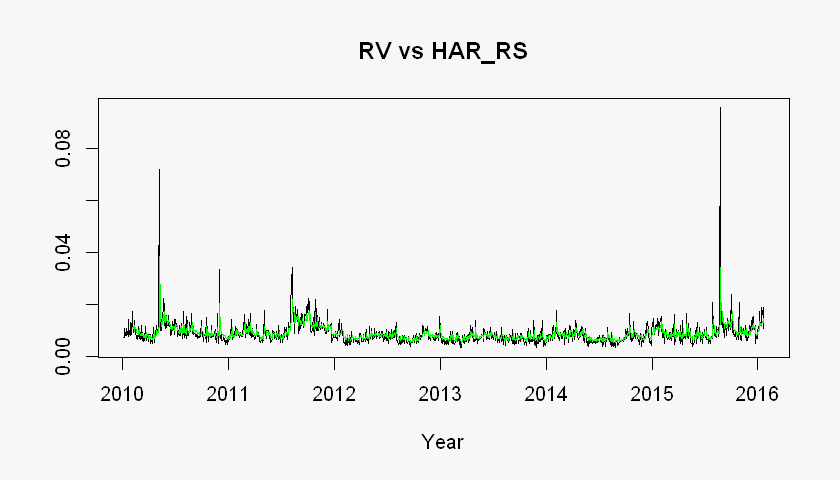

In [30]:
HAR_RS <- HAR_RS_fit$fitted.values
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day, xlab='Year', ylab=NA, main= "RV vs HAR_RS")
lines(zoo(HAR_RS), col = r_col[3])


###  (4). HAR-Rskew-RKurt

**HAR with Rkurt and RSkew has the form:**
$$RV_t = \alpha  + \beta_1 RV{t-1} + \beta_2 RV_{t-1}^{(5)} + \beta_3 RV_{t-1}^{(22)} + \beta_4 RKurt_{t-1} + \beta_5 RSkew_{t-1} + u_t.$$
**RV is Realized Volatility.**

In [31]:
HAR_KS_fit<-lm(RV_day[23:TT] ~ RV_day[22:(TT - 1)] + RV5[18:(T5 - 1)] 
    + RV22[1:(T22 - 1)] + RV_RK[22:(TT - 1)] + RV_RS[22:(TT - 1)])

summary(HAR_KS_fit)


Call:
lm(formula = RV_day[23:TT] ~ RV_day[22:(TT - 1)] + RV5[18:(T5 - 
    1)] + RV22[1:(T22 - 1)] + RV_RK[22:(TT - 1)] + RV_RS[22:(TT - 
    1)])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.017732 -0.001562 -0.000363  0.000979  0.083066 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          2.300e-03  3.791e-04   6.066 1.66e-09 ***
RV_day[22:(TT - 1)]  3.911e-01  3.251e-02  12.030  < 2e-16 ***
RV5[18:(T5 - 1)]     1.577e-01  5.296e-02   2.979  0.00294 ** 
RV22[1:(T22 - 1)]    2.686e-01  5.806e-02   4.627 4.04e-06 ***
RV_RK[22:(TT - 1)]  -1.104e-04  2.125e-05  -5.194 2.34e-07 ***
RV_RS[22:(TT - 1)]  -7.181e-05  8.401e-05  -0.855  0.39278    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.00361 on 1472 degrees of freedom
Multiple R-squared:  0.3162,	Adjusted R-squared:  0.3138 
F-statistic: 136.1 on 5 and 1472 DF,  p-value: < 2.2e-16


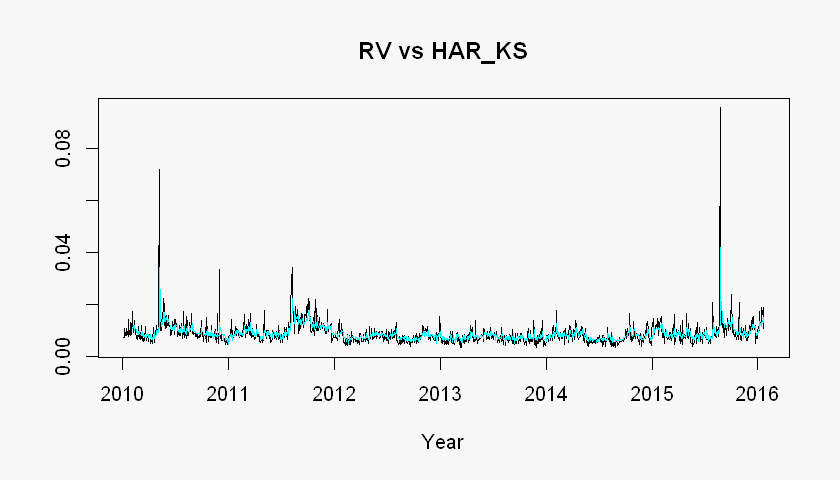

In [32]:
HAR_KS <- HAR_KS_fit$fitted.values

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day, xlab='Year', ylab=NA, main= "RV vs HAR_KS")
lines(zoo(HAR_KS), col = r_col[4])

###  (5). Realized GARCH

**Realized GARCH has the form:**  
$$
\begin{align}
r_t= & \sqrt{h_t}z_t \\
ln(h_t)= & \omega + \beta ln(h_{t-1})+\gamma ln(RV_{t-1})\\
ln(RV_t)= & \xi+ \varphi ln(h_t) + u_t
\end{align}
$$
**RV is Realized Volatility, $ h_t$ is Variance**

In [33]:
real_garchspec<- ugarchspec(variance.model = list(model = 'realGARCH',
    garchOrder = c(1, 1)), mean.model = list(armaOrder=c(0, 0), 
    include.mean=TRUE))

# change the solver = 'hybrid', p13 of the paper of Rugarch package
RGarch_fit <- ugarchfit(real_garchspec, rets, solver = 'hybrid', 
    realizedVol = RV_day)                   
RGarch_fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: realGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000559    0.000294  1.90233 0.057128
omega  -1.095515    0.310397 -3.52941 0.000416
alpha1  0.754499    0.082848  9.10699 0.000000
beta1   0.469083    0.036341 12.90786 0.000000
eta11  -0.050667    0.006729 -7.53003 0.000000
eta21   0.000766    0.001542  0.49648 0.619554
delta   0.560013    0.050148 11.16716 0.000000
lambda  0.244603    0.004483 54.55668 0.000000
xi      0.177743    0.444308  0.40005 0.689123

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000559    0.000242  2.31573 0.020573
omega  -1.095515    0.613905 -1.78450 0.074342
alpha1  0.754499    0.168190  4.48599 0.000007
beta1

**In output fitting result, alpha1 is gamma, telling the influcence of the RV to GARCH, in this case it is 75%, so gamma is very important to GARCH model.** 

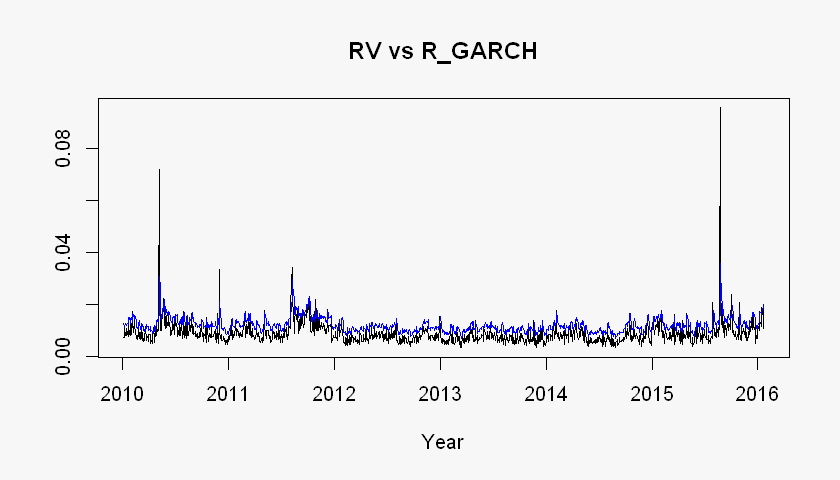

In [34]:
R_GARCH<-xts(RGarch_fit@fit$sigma,order.by = index(RV_day))

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day, xlab='Year', ylab=NA, main= "RV vs R_GARCH")
lines(zoo(R_GARCH), col = r_col[5])

###  (6). ARMA-GARCH

**ARMA-GARCH has the form:**  
$$ a_t = \sigma_t \epsilon_t \\
\sigma_t^2 = \alpha_0 + \alpha_1 a_{t - 1}^2 + \beta_1 \sigma_{t - 1}^2$$

In [35]:
garchspec <- ugarchspec(mean.model = list(armaOrder = c(0, 0)),
        variance.model = list(garchOrder = c(1, 1)))
garch1 <- ugarchfit(garchspec, rets)
garch1


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000616    0.000265   2.3206 0.020306
omega   0.000043    0.000012   3.7489 0.000178
alpha1  0.344244    0.066803   5.1531 0.000000
beta1   0.432719    0.110128   3.9292 0.000085

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000616    0.000344  1.79037 0.073395
omega   0.000043    0.000048  0.90777 0.363997
alpha1  0.344244    0.287421  1.19770 0.231035
beta1   0.432719    0.479608  0.90224 0.366931

LogLikelihood : 4533.01 

Information Criteria
------------------------------------
                    
Akaike       -6.0387
Bayes        -6.0245
Shibata      -6.0387
Hannan-Quinn -6.0334

Weigh

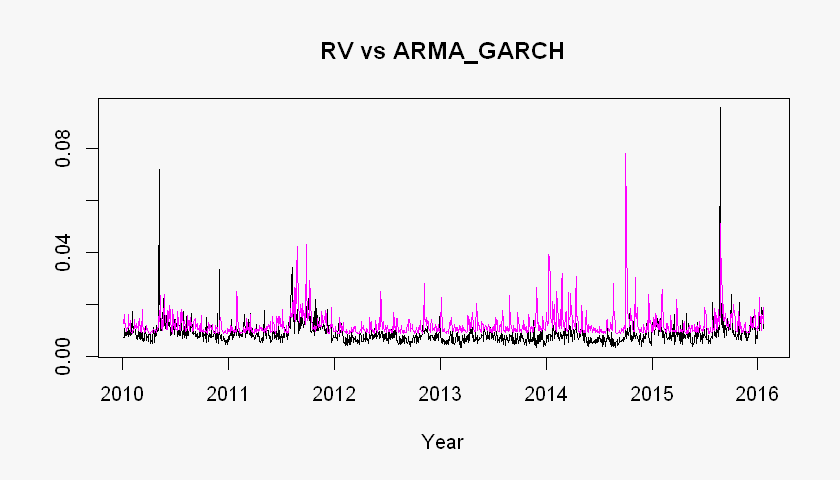

In [36]:
ARMA_GARCH<-xts(garch1@fit$sigma,order.by = index(RV_day))
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day, xlab='Year', ylab=NA, 
         main= "RV vs ARMA_GARCH")
lines(zoo(ARMA_GARCH), col = r_col[6])

**By comparation, the difference between RV and ARMA_GARCH is bigger than other models, it is part because ARMA_GARCH In-sample fit uses Returns data instead of RV data, as we analysis at Part 1, some high valatility in Returns are not reflected in RV samples.**

###  (7). Compare Qualitative Differences of Models

**First we compare all models together, then we seperate HAR and GARCH type models into two groups to do further ananlysis, we also zoom into specific time peirods to observe the detailed characters of those models.** 

* **Compare ALL models**

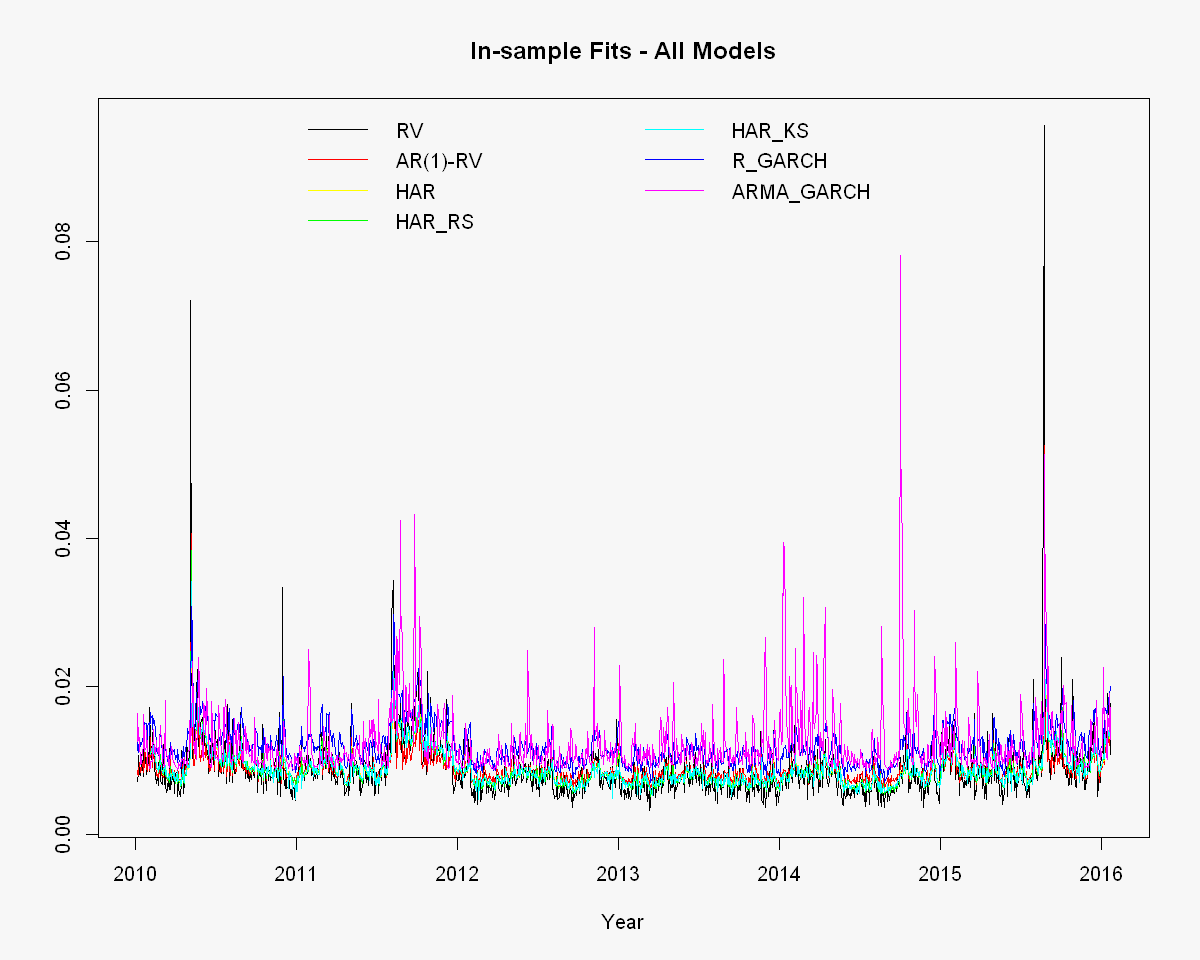

In [37]:
par(bg = "#f7f7f7")
options(repr.plot.width = 10, repr.plot.height = 8)

model_name <- c("AR(1)-RV", "HAR", 'HAR_RS',
    'HAR_KS','R_GARCH',  'ARMA_GARCH' )
fit_l <- list(AR1, HAR, HAR_RS, HAR_KS, R_GARCH, ARMA_GARCH)
model_n <- length(fit_l)
legend_col <- c("black", r_col)
legend_n <- c("RV", model_name)

plot.zoo(RV_day, xlab='Year', ylab=NA, 
         main= "In-sample Fits - All Models")
for (i in 1:model_n) {
    lines(zoo(fit_l[[i]]), col = r_col[i])
}
legend("top", legend = legend_n, col = legend_col, 
       ncol=2, lwd = 1, bty="n")


**From the plot, ARMA-GARCH is the worst model for In-sample fit, because of using Returns data instead of RV directly, and as we already mentioned before, those two data set are not exactly matched.**

* **Compare HAR-Type models**

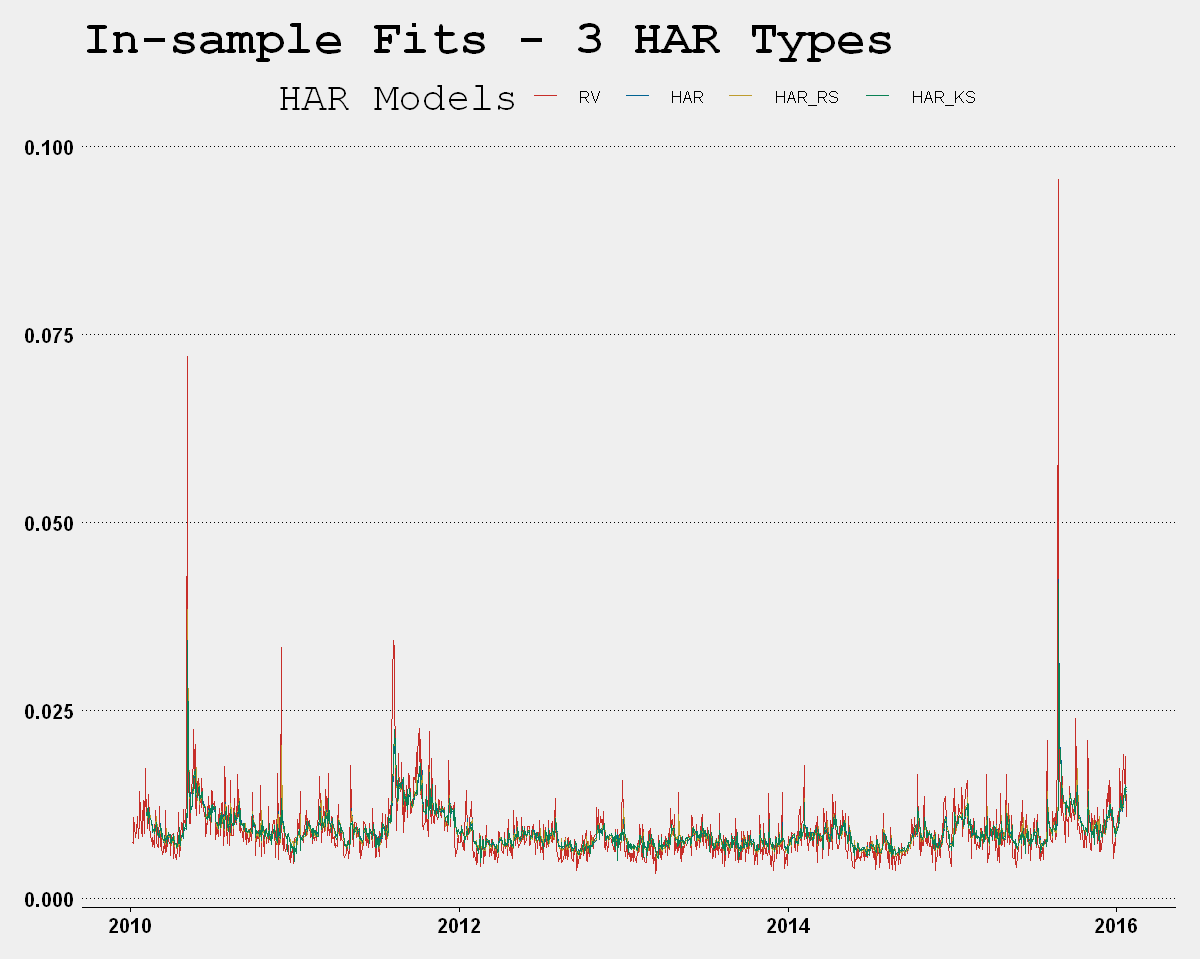

In [38]:
options(repr.plot.width = 10, repr.plot.height = 8)

options(repr.plot.width = 10, repr.plot.height = 8)
model_HAR <- merge(RV_day, HAR, HAR_RS, HAR_KS, all=TRUE)
autoplot(model_HAR, facets = NULL) + geom_line() + 
    theme_wsj(color = "gray") + scale_colour_wsj("colors6","HAR Models") +
    ggtitle("In-sample Fits - 3 HAR Types")


**Zoom in to 2012:  
Because the difference among three HAR type models are quite small, so we need to choose some quiet period for comparison.**

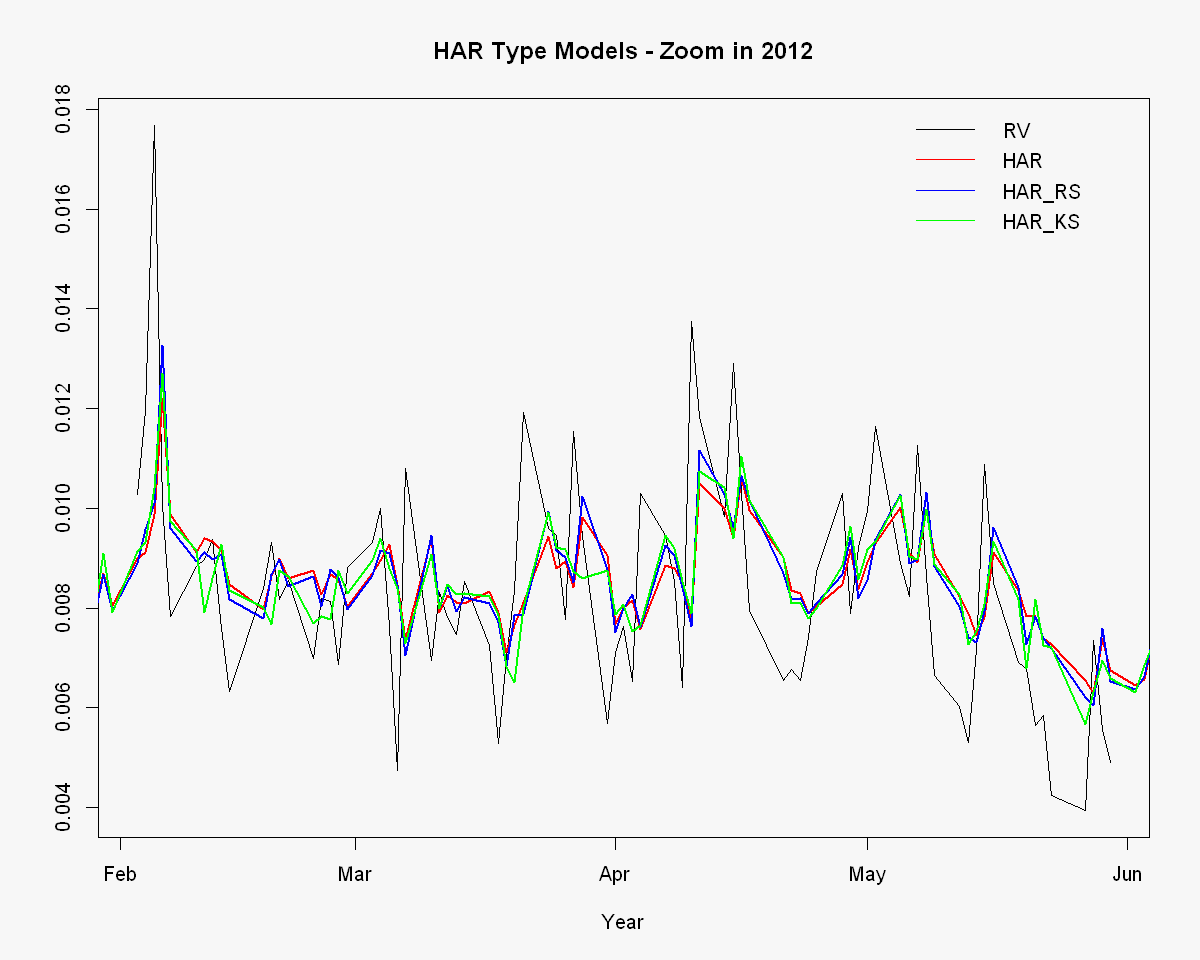

In [39]:
par(bg = "#f7f7f7")
options(repr.plot.width = 10, repr.plot.height = 8)

d_range <- '2014-02/2014-05'
plot.zoo(RV_day[d_range], xlab='Year', ylab=NA, 
         main= "HAR Type Models - Zoom in 2012")
for (i in 2:4) {
    lines(zoo(fit_l[[i]]), col = c_col4[i], lwd = 2)
}
legend("topright", legend = c("RV", "HAR", 'HAR_RS',
    'HAR_KS'), col = c_col4, lwd = 1, bty="n")


**Three HAR models almost match each other, the only difference we could tell from this plot is that HAR-RS is higher when RV is higher. The reason is we especially chose the period of more bad news, which has more negative returns. Because HAR-RS model could better capture the Leverage Effect, so after bad news, HAR-RS would show higher volatility.   
Because in HAR-RS，Semi-Variance information are only modelled in $RV_{t-1}$ component, which means it only captures short-term information, such as Jumps. And in HAR-KS, Skewness also mostly captures Jumps information.  Since Jumps normally are only small portion of the variance of whole data set(depends on asset type), so the difference among HAR types model results are not big.**

* **Compare GARCH-Type models**

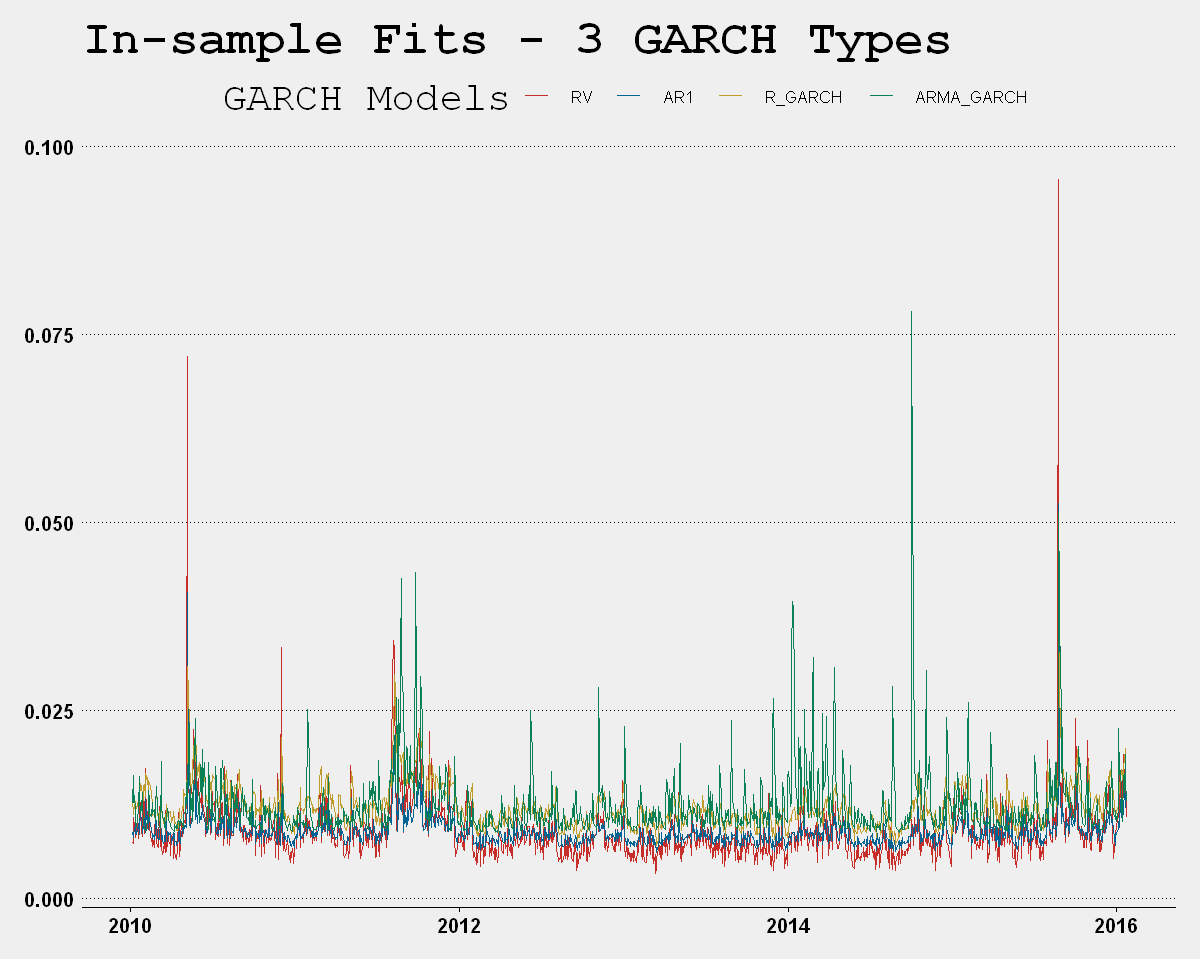

In [40]:
model_GARCH <- merge(RV_day, AR1, R_GARCH, ARMA_GARCH, all=TRUE)
options(repr.plot.width = 10, repr.plot.height = 8)
autoplot(model_GARCH, facets = NULL) + geom_line() + 
    theme_wsj(color = "gray") + scale_colour_wsj("colors6","GARCH Models") +
    ggtitle("In-sample Fits - 3 GARCH Types")

**Zoom in to 2015:  
Because the results of these 3 samples are quite different, so we choose a period with high spike for comparation.**

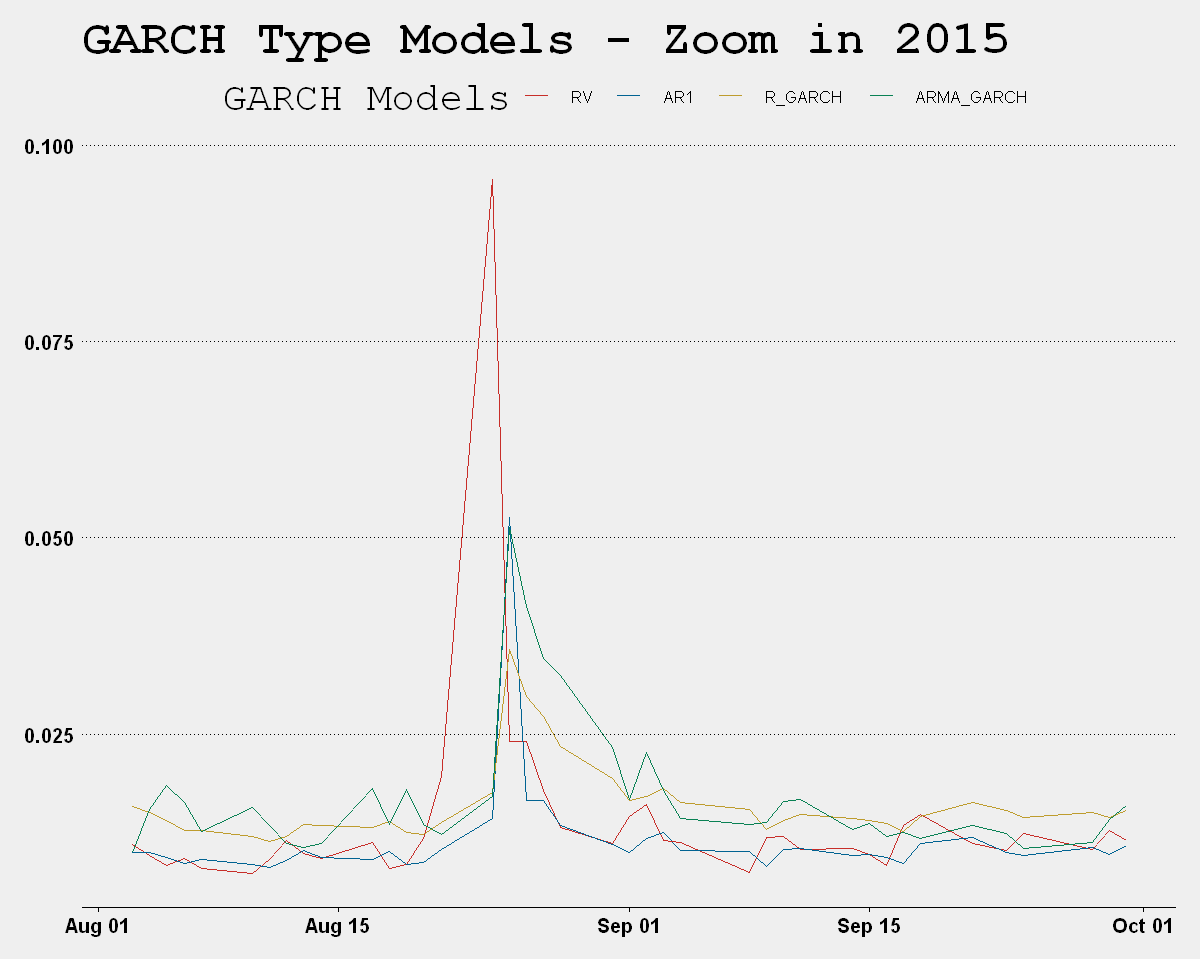

In [41]:
d_range <- '2015-08/2015-09'
autoplot(model_GARCH[d_range], facets = NULL) + geom_line() + 
    theme_wsj(color = "gray")+  scale_colour_wsj("colors6","GARCH Models") +
    ggtitle("GARCH Type Models - Zoom in 2015")


**AR(1) seems fit the best with sample data, then R-GARCH is the scecond place, ARMA-GARCH has longer memory after  spike or Jump.**

* **All model in 2015(high spike period)**

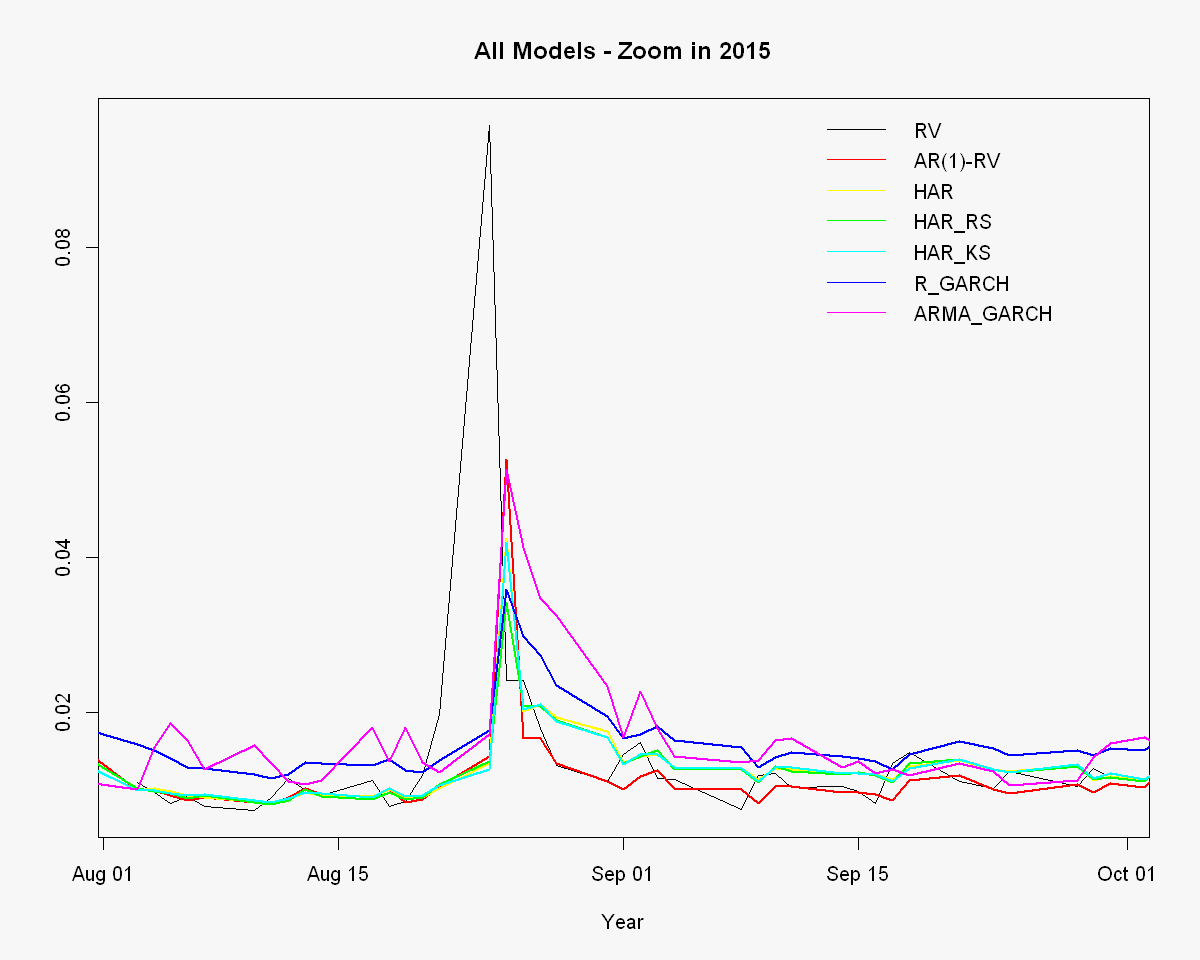

In [42]:
par(bg = "#f7f7f7")
options(repr.plot.width = 10, repr.plot.height = 8)
d_range <- '2015-08/2015-09'


plot.zoo(RV_day[d_range], xlab='Year', ylab=NA, 
         main= "All Models - Zoom in 2015")
for (i in 1:model_n) {
    lines(zoo(fit_l[[i]]), col = r_col[i], lwd = 2)
}
legend("topright", legend = legend_n, col = legend_col, 
       lwd = 1, bty="n")




**After the volatility spike, ARMA_GARCH model takes the longest time to adjust back to normal level, while R_GARCH model adjusts the volatility level faster.     
This is because conventianl GARCH takes information from returns to adjust value of conditinal variance, so it takes longer time for GARCH to adjust to the new volatility. While Realized GARCH includes realized volatility into the volatility equation, which helps GARCH to catch True volatility information, and improves the fit.**

# Part 3. Forecasts

**Compare an out-of-sample forecasting performance of the models from previous part using two forecasting schemes:  
(i) Expanding window, with starting window length of 750.  
(ii) Rolling window, with the window length 750.  
Plot and compare forecast errors from all models, compute loss functions (MSE and MAE), compare model forecasts statistically using the Diebold-Mariano test (use the MSE loss). Evaluate all single model forecasts with the Minzer-Zarnowitz regression.**

* **Setup parameters**

**To make forecast Rooling window length to 750, we need to set the offset parameter w_l as 749.**

In [43]:
# rolling window length is 3 years big
w_l <- 749 
# rolling range for next 3 years
n_for <- nrow(adp) - w_l - 1
w_l
n_for

[1] 749

[1] 750

**Use window length of 750 for fit-in sample, by using first 3 years data of 2010-2012. Then do the out-of-sample forecast for rest of time range, then compare with the "True" data of the last 3 years of 2013-2015.** 

###  (1). AR(1)-RV Forecast

**In this first out-of-sample forecast model, we also explain those forecast methods would be used in this project, as well as some testing to verify reasonable forecast results.**

* **AR(1) Rolling Window**

**i. Forecast using the first window by arima function**  
First window is from RV_day[1:750]

In [44]:
# lm forecast test
x <- 1
AR1_fit <- arima(RV_day[x:(x+w_l)],
        order=c(1,0,0))
# last sample
print("Last fit-in sample index:")
w_l+x
print("Window begining date:")
RV_day[x]
print("Window ending date:")
RV_day[w_l+x]
AR1_fit

[1] "Last fit-in sample index:"


[1] 750

[1] "Window begining date:"


                    RV
2010-01-05 0.007350539

[1] "Window ending date:"


                    RV
2013-01-10 0.006580757


Call:
arima(x = RV_day[x:(x + w_l)], order = c(1, 0, 0))

Coefficients:
         ar1  intercept
      0.5558     0.0095
s.e.  0.0303     0.0003

sigma^2 estimated as 1.275e-05:  log likelihood = 3161.75,  aic = -6317.51

**As the last day data for the sample is 0.00658, AR1 has 0.55 as fit-in smaple.**

In [45]:
AR1_forecast1 <- forecast(AR1_fit, h = 1)
AR1_forecast1

    Point Forecast       Lo 80      Hi 80        Lo 95      Hi 95
751    0.007861648 0.003284978 0.01243832 0.0008622346 0.01486106

In [46]:
AR1_forecast <- predict(AR1_fit)

# real next day data
print("True value:")
RV_day[(x+w_l):(x+w_l+1)]
print("Forecast value for 2013-01-11:")
AR1_forecast$pred
               


[1] "True value:"


                    RV
2013-01-10 0.006580757
2013-01-11 0.005784268

[1] "Forecast value for 2013-01-11:"


A Time Series:
[1] 0.007861648

**True data on 2014-01-11 is 0.00578, forecast data is 0.00786.**

**ii. check the forecast result of high spike day**

In [47]:
RV_day['2015-08-20/2015-08-26']
print("Max RV date:")
index(RV_day)[spike]
print("Max RV index:")
spike
# last sample day as spike
x <- spike - w_l
print("Window begining index:")
x

                   RV
2015-08-20 0.01178037
2015-08-21 0.01968633
2015-08-24 0.09566730
2015-08-25 0.02410682
2015-08-26 0.02410816

[1] "Max RV date:"


[1] "2015-08-24"

[1] "Max RV index:"


[1] 1404

[1] "Window begining index:"


[1] 655

In [48]:
# test the spike forecasting  for fit-in smaple
AR1_fit <- arima(RV_day[x:(x+w_l)],c(1,0,0))
# last sample
print("Window begining date:")
RV_day[x]
print("Window ending date:")
RV_day[w_l+x]
AR1_fit

[1] "Window begining date:"


                    RV
2012-08-20 0.005092052

[1] "Window ending date:"


                  RV
2015-08-24 0.0956673


Call:
arima(x = RV_day[x:(x + w_l)], order = c(1, 0, 0))

Coefficients:
         ar1  intercept
      0.7548     0.0082
s.e.  0.0552     0.0005

sigma^2 estimated as 1.259e-05:  log likelihood = 3166.26,  aic = -6326.51

**As the last day fit-in data from the sample is 0.0956, AR1 has 0.75 as fit-in smaple, higher than the result of first window as 0.55.**

In [49]:
# forecast the next day value as 2015-08-25
AR1_forecast <- predict(AR1_fit)
# real next day data
print("True value:")
RV_day[(x+w_l):(x+w_l+1)]   
print("Forecast value for 2015-08-25:")
AR1_forecast$pred
   

[1] "True value:"


                   RV
2015-08-24 0.09566730
2015-08-25 0.02410682

[1] "Forecast value for 2015-08-25:"


A Time Series:
[1] 0.07420604

**After the spike value of 0.0956, the Real data on 2015-08-25 is 0.0241, forecast data is 0.0742, both are much higher than the result from the first window.**

**iii. Forecast by lm function**

In [50]:
# Forecast from first window 
x <- 1
dep <- as.numeric(RV_day[(x+1):(x+w_l)])
ind <- as.numeric(RV_day[x:(x+w_l-1)])
AR1_lm_fit <- lm(dep ~ ind)
AR1_lm_fit

#a <- c(1,2,3)
lastday <- as.numeric(RV_day[x+w_l])
new <- data.frame(ind = lastday )
print("Forecast value:")
predict(AR1_lm_fit, new)
print("True value:")
RV_day[(x+w_l):(x+w_l+1)] 


Call:
lm(formula = dep ~ ind)

Coefficients:
(Intercept)          ind  
   0.004199     0.556448  


[1] "Forecast value:"


1 
0.007861016

[1] "True value:"


                    RV
2013-01-10 0.006580757
2013-01-11 0.005784268

In [51]:
# Forecast after the spike day 2015-08-25
x <- spike - w_l
dep <- as.numeric(RV_day[(x+1):(x+w_l)])
ind <- as.numeric(RV_day[x:(x+w_l-1)])
AR1_lm_fit <- lm(dep ~ ind)
AR1_lm_fit
# use the last day sample data for forecasting
lastday <- as.numeric(RV_day[(w_l+ x)])
new <- data.frame(ind = lastday )
print("True value:")
RV_day[(x+w_l):(x+w_l+1)]
print("Forecast value:")
predict(AR1_lm_fit, new)



Call:
lm(formula = dep ~ ind)

Coefficients:
(Intercept)          ind  
   0.001969     0.758753  


[1] "True value:"


                   RV
2015-08-24 0.09566730
2015-08-25 0.02410682

[1] "Forecast value:"


1 
0.07455726

**The reslut of lm predict is similar to the result from arima forecast.**

**iv. Verify forecast result by plot**

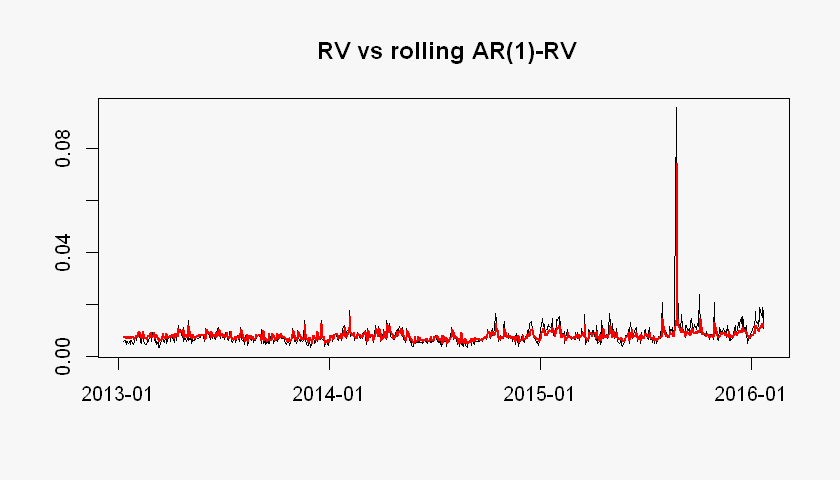

In [52]:
# fit-in window size is fixed at w_l as RV_day[x:(w_l+x),]
# then the fixed size window moves 750 times as n_for
AR1_roll_fit<-lapply( 1:n_for, 
    function(x) arima(RV_day[x:(x+w_l)],c(1,0,0)) )        
# use arima predict function for forecasting
AR1_roll_for <- sapply(1:n_for, 
    function (x) predict(AR1_roll_fit[[x]])$pred)
AR1_roll <- xts(AR1_roll_for,order.by = index(
    rets[(w_l+2):(w_l+1+n_for)]))

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA,  ylab=NA,
    format='%Y-%m', main=" RV vs rolling AR(1)-RV")
lines(zoo(AR1_roll),col="red", lwd=2)

* **AR(1） Expanding Window**

Set the beginning of the window always as 1

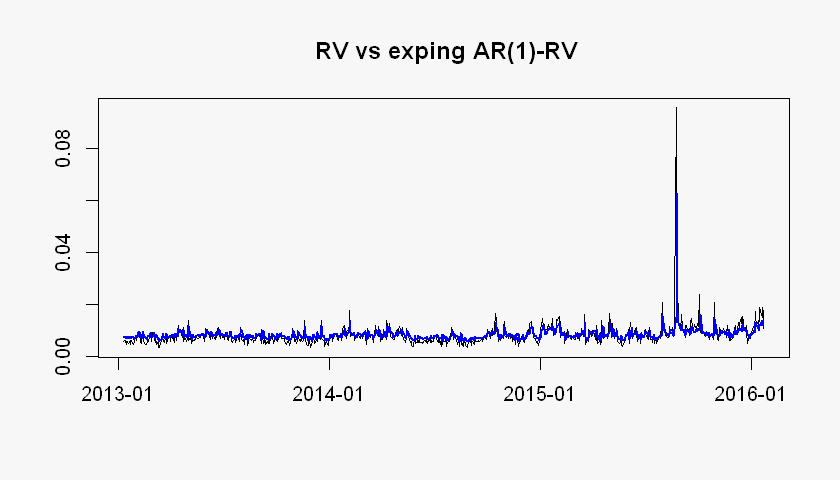

In [53]:
# fit-in window size is expanding at RV_day[1:(w_l+x),]
AR1_exp_fit<-lapply( 1:n_for, function(x) arima(RV_day[1:(x+w_l)],c(1,0,0)) )                   
AR1_exp_for <- sapply(1:n_for, function (x) predict(AR1_exp_fit[[x]])$pred)
AR1_exp <- xts(AR1_exp_for,order.by = index(rets[(w_l+2):(w_l+1+n_for)]))

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA, ylab=NA,
    format='%Y-%m', main=" RV vs exping AR(1)-RV")
lines(zoo(AR1_exp),col="blue", lwd=2)                            

###  (2). HAR Forecast

* **HAR Rolling Window**

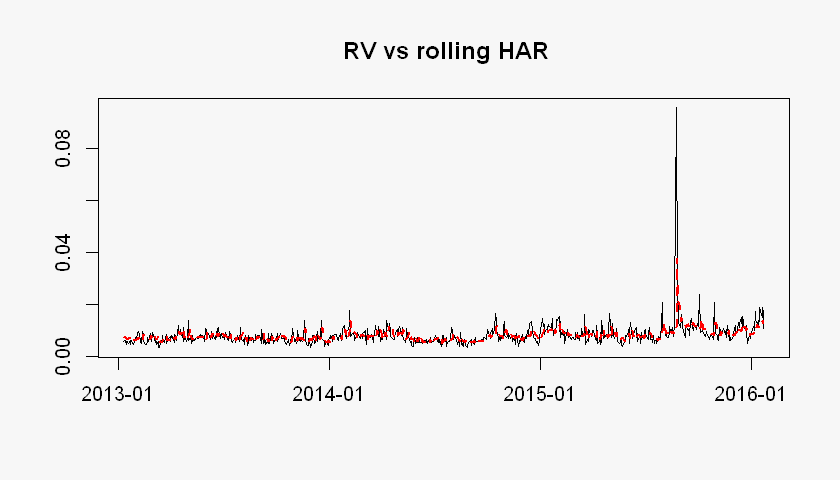

In [54]:
# fit-in window size is fixed at RV_day[x:(w_l+x),]

HAR_roll_fit <- lapply(1:n_for, function(x) HARmodel(data = RV_day[x:(w_l+x),] , 
    periods = c(1,5,22), type = "HAR", h = 1, transform = NULL, inputType = "RM"))
HAR_roll_for <- sapply(1:n_for, function (x) predict(HAR_roll_fit[[x]]))                       
HAR_roll <- xts(HAR_roll_for,order.by = index(rets[(w_l+2):(w_l+1+n_for)]))
    
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA, ylab=NA,
    format='%Y-%m', main=" RV vs rolling HAR")
lines(zoo(HAR_roll),col="red", lwd=2, lty=2)


* **HAR Expanding Window**

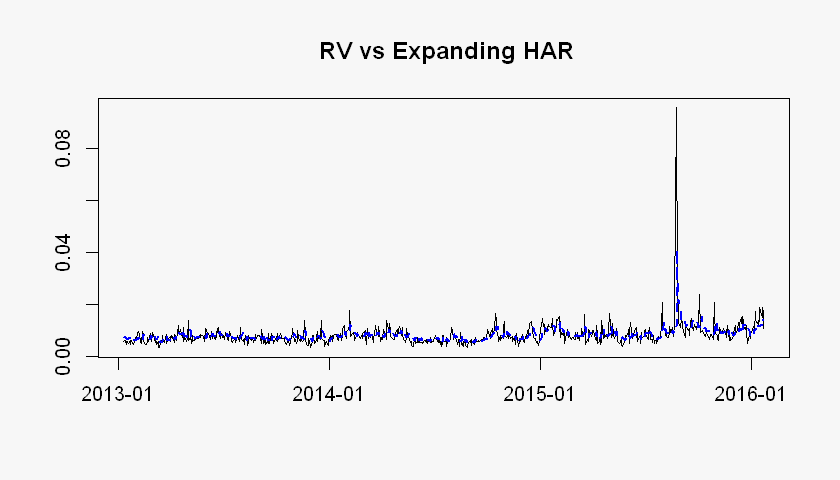

In [55]:
# fit-in window size is expanding at RV_day[1:(w_l+x),]
HAR_exp_fit <- lapply(1:n_for, function(x) HARmodel(data = RV_day[1:(w_l+x),] , 
    periods = c(1,5,22), type = "HAR", h = 1, transform = NULL, inputType = "RM"))
HAR_exp_for<-sapply(1:n_for, function (x) predict(HAR_exp_fit[[x]]))
HAR_exp <- xts(HAR_exp_for,order.by = index(rets[(w_l+2):(w_l+1+n_for)]))               
                

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA,ylab=NA,
    format='%Y-%m', main=" RV vs Expanding HAR")
lines(zoo(HAR_exp),col="blue", lwd=2,lty=2)


###  (3). HAR-RS Forecast

* **Create new function: forecast_HAR_RS()**

In [56]:
# Input parameters: x is rolling window postion
# exp is the flag of rolling or expanding window, default is expanding
# return n.ahead=1 forecast RV
forecast_HAR_RS <- function (x, exp = 1 ) {
    
    dep <- as.numeric(RV_day[(exp+22):(x+w_l)])
    ind_p <- as.numeric(RV_p[(exp+22-1):(x+w_l-1)])
    ind_n <- as.numeric(RV_n[(exp+22-1):(x+w_l-1)])
    ind_5 <- as.numeric(RV5[(exp+22-5):(x+w_l-5)])
    ind_22 <- as.numeric(RV22[exp:(x+w_l-22)])
    
    # use lm() regression for HAR_RS fit

    HAR_RS_fit <- lm(dep ~ ind_p + ind_n + ind_5 + ind_22)

    # use the last day sample data for out-of-sample forecasting
    ind_p <- as.numeric(RV_p[x+w_l])
    ind_n <- as.numeric(RV_n[x+w_l])
    ind_5 <- as.numeric(RV5[x+w_l-4])
    ind_22 <- as.numeric(RV22[x+w_l-21])

    new <- data.frame(ind_p,ind_n,ind_5, ind_22)
    return(predict(HAR_RS_fit, new)) 
}

# test for first day and spike day forecast
x <- 1
print("First window rolling")
forecast_HAR_RS( x, x) #rolling
print("First window expanding")
forecast_HAR_RS( x) # expanding

x <- spike - w_l # forecast the RV right after spike day
x
print("Spike forecast rolling")
forecast_HAR_RS( x, x) #rolling
print("Spike forecast expanding")
forecast_HAR_RS( x) # expanding

[1] "First window rolling"


1 
0.007333398

[1] "First window expanding"


1 
0.007333398

[1] 655

[1] "Spike forecast rolling"


1 
0.07048146

[1] "Spike forecast expanding"


1 
0.04916458

* **HAR_RS Rolling Window**

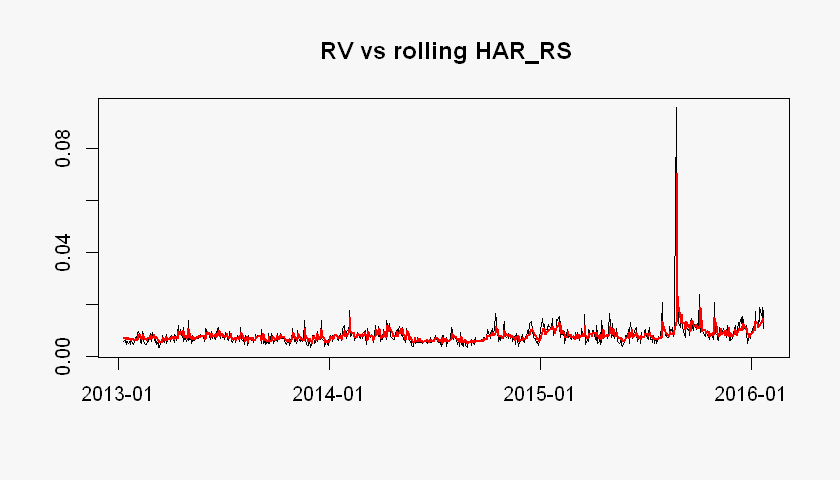

In [57]:
HAR_RS_roll_for <- sapply(1:n_for, 
    function (x) forecast_HAR_RS( x, x))                      

HAR_RS_roll <- xts(HAR_RS_roll_for,order.by = index(
    rets[(w_l+2):(w_l+1+n_for)]))

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA, ylab=NA,
    format='%Y-%m', main=" RV vs rolling HAR_RS")
lines(zoo(HAR_RS_roll),col="red", lwd=2)

* **HAR_RS Expanding Window**

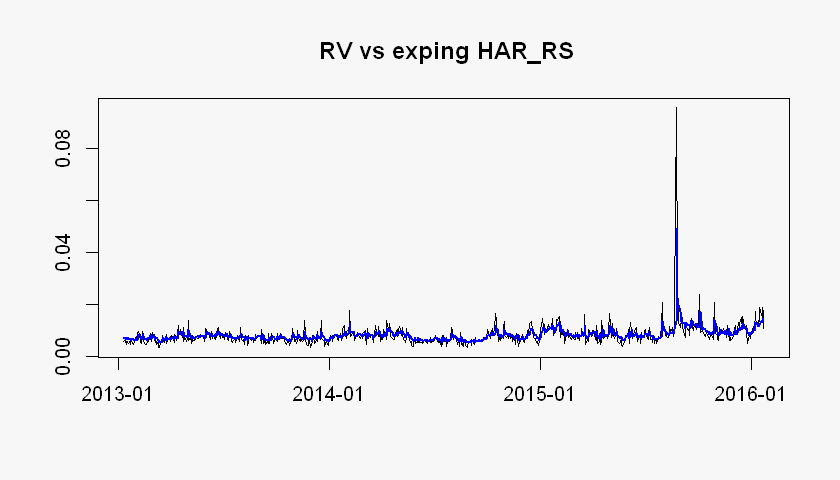

In [58]:
HAR_RS_exp_for <- sapply(1:n_for, 
        function (x) forecast_HAR_RS( x ))                      

HAR_RS_exp <- xts(HAR_RS_exp_for,order.by = index(
    rets[(w_l+2):(w_l+1+n_for)]))

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA, ylab=NA,
        format='%Y-%m', main=" RV vs exping HAR_RS")
lines(zoo(HAR_RS_exp),col="blue", lwd=2)



###  (4). HAR-Rskew-RKurt Forecast

* **Create new function:  forecast_HAR_KS()**

In [59]:
# Input parameters: x is rolling window postion
# exp is the flag of rolling or expanding window, default is expanding
# return n.ahead=1 forecast RV
forecast_HAR_KS <- function (x, exp = 1 ) {
    
    dep <- as.numeric(RV_day[(exp+22):(x+w_l)])
    ind_1 <- as.numeric(RV_day[(exp+22-1):(x+w_l-1)])
    ind_5 <- as.numeric(RV5[(exp+22-5):(x+w_l-5)])
    ind_22 <- as.numeric(RV22[exp:(x+w_l-22)])
    ind_rk <- as.numeric(RV_RK[(exp+22-1):(x+w_l-1)])
    ind_rs <- as.numeric(RV_RS[(exp+22-1):(x+w_l-1)])
    
    # use lm() regression for HAR_KS fit

    HAR_RS_fit <- lm(dep ~ ind_1 + ind_5 + ind_22 + ind_rk + ind_rs)

    # use the last day sample data for out-of-sample forecasting
    ind_1 <- as.numeric(RV_p[x+w_l])
    ind_5 <- as.numeric(RV5[x+w_l-4])
    ind_22 <- as.numeric(RV22[x+w_l-21])
    ind_rk <- as.numeric(RV_n[x+w_l])
    ind_rs <- as.numeric(RV_n[x+w_l])    
    new <- data.frame(ind_1, ind_5, ind_22, 
            ind_rk, ind_rs)
    
    return(predict(HAR_RS_fit, new)) 
}

# test for first day and spike day forecast
x <- 1
print("First window rolling")
forecast_HAR_KS( x,  x)
print("First window expanding")
forecast_HAR_KS( x)
x <- spike - w_l
x
print("Spike forecast rolling")
forecast_HAR_KS( x,  x)
print("Spike forecast expanding")
forecast_HAR_KS( x)

[1] "First window rolling"


1 
0.00719858

[1] "First window expanding"


1 
0.00719858

[1] 655

[1] "Spike forecast rolling"


1 
0.07236661

[1] "Spike forecast expanding"


1 
0.05579827

* **HAR_KS Rolling Window**

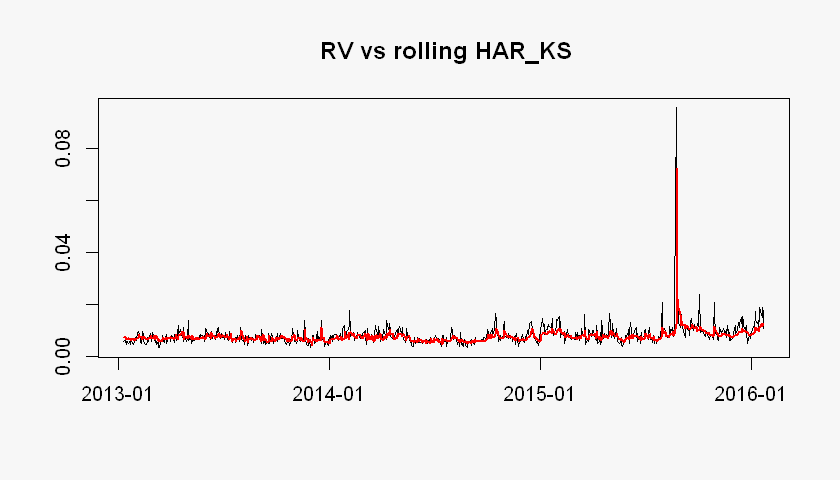

In [60]:
HAR_KS_roll_for <- sapply(1:n_for, 
        function (x) forecast_HAR_KS(x, x))                      

HAR_KS_roll <- xts(HAR_KS_roll_for,order.by = index(
    rets[(w_l+2):(w_l+1+n_for)]))

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA, ylab=NA,
    format='%Y-%m', main=" RV vs rolling HAR_KS")
lines(zoo(HAR_KS_roll),col="red", lwd=2)

* **HAR_KS Expanding Window**

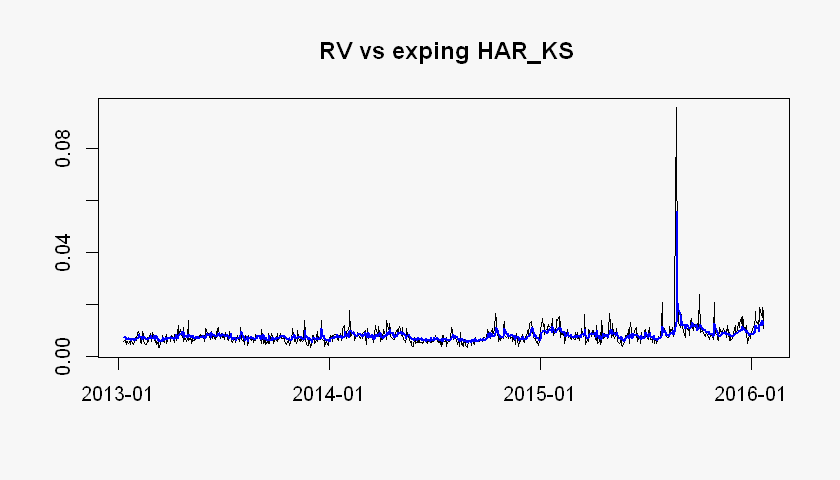

In [61]:
HAR_KS_exp_for <- sapply(1:n_for, function (x) forecast_HAR_KS(x))                      

HAR_KS_exp <- xts(HAR_KS_exp_for,order.by = index(
    rets[(w_l+2):(w_l+1+n_for)]))

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA,
         ylab=NA,format='%Y-%m', main=" RV vs exping HAR_KS")
lines(zoo(HAR_KS_exp),col="blue", lwd=2)



###  (5). Realized GARCH Forecast

* **Create new function: forecast_RGARCH()**

**Because the result of rolling window forecast is very noisy, we have to apply a filter for Winsorization to get cleaning data. If the forecast generate extreme values, we  will take the last recorded forecast result as this window forecast.**

In [62]:
# set up a global variable for Winsorization or Truncation for extreme values.
flag_last <- 0

# Input parameters: x is rolling window postion
# exp is the flag of rolling or expanding window, default is expanding
# return forecast volatility
forecast_RGARCH <- function (x,exp = 1) {
    
    RGarch_fit <- ugarchfit(real_garchspec, rets[exp:(x+w_l)], 
        solver = 'hybrid', realizedVol =  RV_day[exp:(x+w_l)])  
    
    RGARCH_for<- ugarchforecast(RGarch_fit, data = NULL, 
        n.ahead = 1,  n.roll = 0, out.sample = 0)    
    for_res <- RGARCH_for@forecast[["sigmaFor"]]    
    
    # Winsorization out of range values
    if (for_res > 0.05) { 
#        print(for_res)
        for_res <- flag_last 
    } else { 
        flag_last <<- for_res
    }  
    return(for_res)    
}

# test for first day and spike day forecast
x <- 1
print("First window rolling")
print(forecast_RGARCH( x,  x))
print("First window expanding")
print(forecast_RGARCH( x))

x <- spike - w_l
print("Spike forecast rolling")
print(forecast_RGARCH( x,  x))
print("Spike forecast expanding")
print(forecast_RGARCH( x))
               

[1] "First window rolling"
     2013-01-10
T+1 0.003733243
[1] "First window expanding"
     2013-01-10
T+1 0.003754877
[1] "Spike forecast rolling"
    2015-08-24
T+1 0.03202583
[1] "Spike forecast expanding"
    2015-08-24
T+1 0.03987155


* **R_GARCH Rolling Window**

<span style='background: yellow'>**This step takes 16 minutes, do not run it unless going for coffee.**</span>

   user  system elapsed 
1019.71   88.07  677.37 

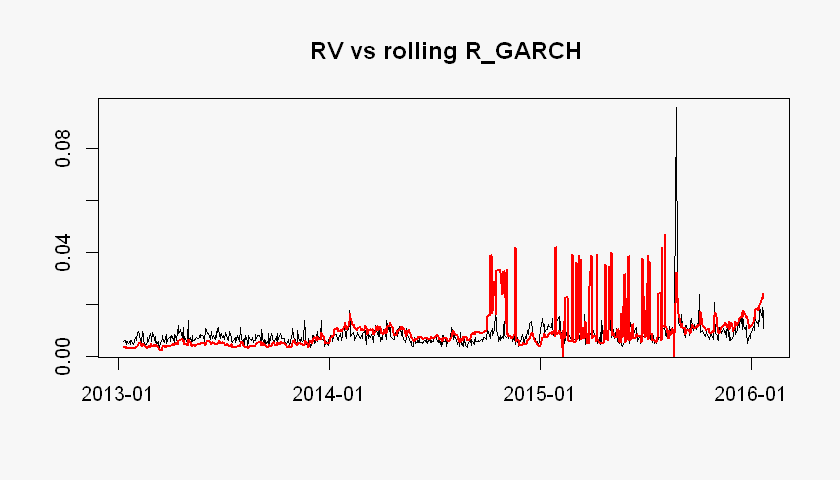

In [63]:
system.time(
    R_GARCH_roll_for <- sapply(1:n_for, function (x) forecast_RGARCH(x, x))     
)
R_GARCH_roll <- xts(R_GARCH_roll_for, order.by = index(
    rets[(w_l+2):(w_l+1+n_for)]))

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA, ylab=NA,
    format='%Y-%m', main=" RV vs rolling R_GARCH")
lines(zoo(R_GARCH_roll),col="red", lwd=2)


**We can see the forecast result for rolling window is really noisy even after winsorization(Truncation) during the period of 2015, the reason could be those return spikes such as 2014-10-01 are not included in RV data.**

* **R_GARCH Expanding Window**

<span style='background: yellow'>**This step takes 20 minutes, do not run it unless going for coffee.**</span>

   user  system elapsed 
1302.17   93.91  947.62 

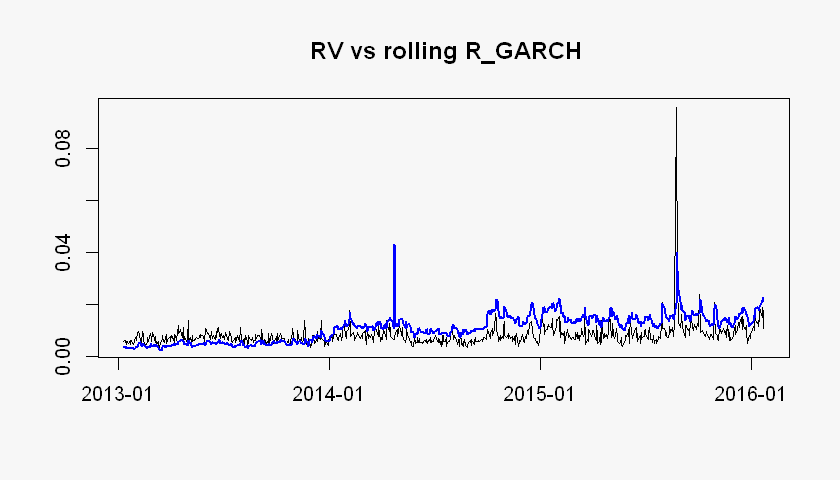

In [64]:
system.time(
    R_GARCH_exp_for <- sapply(1:n_for, function (x) forecast_RGARCH(x))     
)
R_GARCH_exp <- xts(R_GARCH_exp_for, order.by = index(
    rets[(w_l+2):(w_l+1+n_for)]))

par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA,
         ylab=NA,format='%Y-%m', main=" RV vs rolling R_GARCH")
lines(zoo(R_GARCH_exp),col="blue", lwd=2)

###  (6). ARMA-GARCH Forecast

* **Create new function: forecast_GARCH()**

In [65]:
# Input parameters: x is rolling window postion
# exp is the flag of rolling or expanding window, default is expanding
forecast_GARCH <- function (x, exp = 1 ) {    
    Garch_fit <- ugarchfit(garchspec, 100*rets[exp:(x+w_l)])      
    GARCH_for<- ugarchforecast(Garch_fit, data = NULL, 
        n.ahead = 1,  n.roll = 0, out.sample = 0)      
    return(GARCH_for@forecast[["sigmaFor"]]/100)    
}

# test for first day and spike day forecast
x <- 1
print("First window rolling")
print(forecast_GARCH( x,  x))
print("First window expanding")
print(forecast_GARCH( x))

x <- spike - w_l
print("Spike forecast rolling")
print(forecast_GARCH( x,  x))
print("Spike forecast expanding")
print(forecast_GARCH( x))

[1] "First window rolling"
    2013-01-10
T+1  0.0107721
[1] "First window expanding"
    2013-01-10
T+1  0.0107721
[1] "Spike forecast rolling"
    2015-08-24
T+1 0.06442026
[1] "Spike forecast expanding"
    2015-08-24
T+1 0.05586805


* **ARMA_GARCH Rolling Window**  

**First use the manual way to forecast  
<span style='background: lightyellow'>This step takes 1.5 minutes**</span>.

In [66]:
# Manual way
# ret_day[x:(x+w_l)]  beginning day rolls to day x in every loop
system.time(
    GARCH_roll<-lapply( 1:n_for, function(x) ugarchfit(garchspec,
        100 * rets[x:(x+w_l)]))
)
# forecast result is 2013-2016 three years 

GARCH_roll_for<-lapply(1:n_for, function(x) ugarchforecast(GARCH_roll[[x]], 
        data = NULL, n.ahead = 1, n.roll = 0, out.sample = 0))

# set to xts format   
sigma_GARCH_roll_for<- do.call(rbind,lapply(1:n_for, 
        function(x) GARCH_roll_for[[x]]@forecast[["sigmaFor"]]))                                           
sigma_GARCH_roll_for <- xts(sigma_GARCH_roll_for,
        order.by = index(rets[(w_l+2):(w_l+1+n_for)]))/100

head(sigma_GARCH_roll_for,3)                                         

   user  system elapsed 
  89.22    0.03   90.33 

           2013-01-10
2013-01-11 0.01077210
2013-01-14 0.01043899
2013-01-15 0.01036064

**Then use ugarchroll function to forecast  
<span style='background: lightyellow'>This step takes 1.5 minutes**</span>.

In [67]:
# Use ugarchroll function
# set refit.window as "moving"
system.time(
    GARCH_roll<-ugarchroll(garchspec, 100 * rets[1:(w_l+n_for+1),], 
            n.ahead = 1, forecast.length = n_for, n.start = NULL, 
            refit.every = 1, refit.window = c("moving"), window.size = w_l, 
            solver = "solnp", fit.control = list(), solver.control = list(), 
            calculate.VaR = FALSE, cluster = NULL, keep.coef = TRUE)
)

# set to xts format 
ARMA_GARCH_roll <- xts(GARCH_roll@forecast$density$Sigma,
        order.by = index(rets[(w_l+2):(w_l+1+n_for)]))/100

# Check the results of different method
sum(sigma_GARCH_roll_for == ARMA_GARCH_roll)

head(ARMA_GARCH_roll,3)


   user  system elapsed 
  92.08    0.08   92.17 

[1] 750

                 [,1]
2013-01-11 0.01077210
2013-01-14 0.01043899
2013-01-15 0.01036064

**By comparation, we can see both mannual method and ugarchroll function provide the same results.**

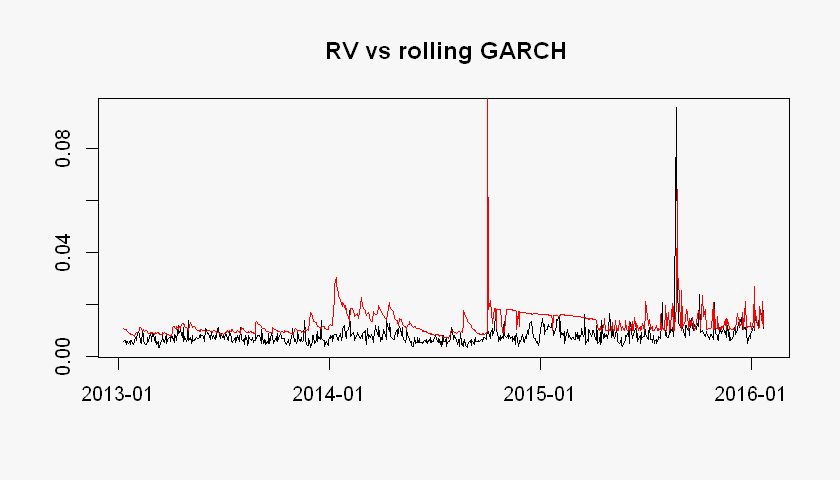

In [68]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA, ylab=NA,
    format='%Y-%m', main=" RV vs rolling GARCH")
lines(zoo(ARMA_GARCH_roll),col="red")

* **ARMA_GARCH Expanding Window**

**Manual way   
<span style='background: lightyellow'>This step takes 2 minutes**</span>.

In [69]:
# Manual way 
# use same garchspec config
# ret_day[1:(x+w_l)]  beginning day stays at day 1
# so window is expanding

system.time(
    GARCH_exp <- lapply(1:n_for, function(x) ugarchfit(garchspec,
        100 * rets[1:(x+w_l)]))
)
    
GARCH_exp_for<-lapply(1:n_for, function(x) ugarchforecast(GARCH_exp[[x]], 
    data = NULL, n.ahead = 1, n.roll = 0, out.sample = 0))        
sigma_GARCH_exp_for<- do.call(rbind,lapply(1:n_for, 
        function(x) GARCH_exp_for[[x]]@forecast[["sigmaFor"]]))                                             
# need to divide back vol by 100 for comparation                                 
sigma_GARCH_exp_for<-xts(sigma_GARCH_exp_for,
        order.by=index(rets[(w_l+2):(w_l+1+n_for)]))/100        
                                           
head(sigma_GARCH_exp_for,3)

   user  system elapsed 
 103.94    0.04  104.02 

           2013-01-10
2013-01-11 0.01077210
2013-01-14 0.01043227
2013-01-15 0.01035570

**Use ugarchroll function  
<span style='background: lightyellow'>This step takes 2 minutes**</span>.

In [70]:
# Use ugarchroll function
# set refit.window as "recursive"
system.time(
    GARCH_exp <- ugarchroll(garchspec, 100*rets[1:(w_l+n_for+1),], 
        n.ahead = 1, forecast.length = n_for, n.start = NULL, refit.every = 1, 
        refit.window = c("recursive"), window.size = w_l, solver = "solnp", 
        fit.control = list(), solver.control = list(), calculate.VaR = FALSE, 
        cluster = NULL, keep.coef = TRUE)
)
ARMA_GARCH_exp <- xts(GARCH_exp@forecast$density$Sigma,
        order.by = index(rets[(w_l+2):(w_l+1+n_for)]))/100
# testing for diff
sum(sigma_GARCH_exp_for == ARMA_GARCH_exp)

head(ARMA_GARCH_exp,3)

   user  system elapsed 
 108.59    0.02  108.64 

[1] 750

                 [,1]
2013-01-11 0.01077210
2013-01-14 0.01043227
2013-01-15 0.01035570

**By comparation, we can see both mannual method and ugarchroll function provide the same results.**

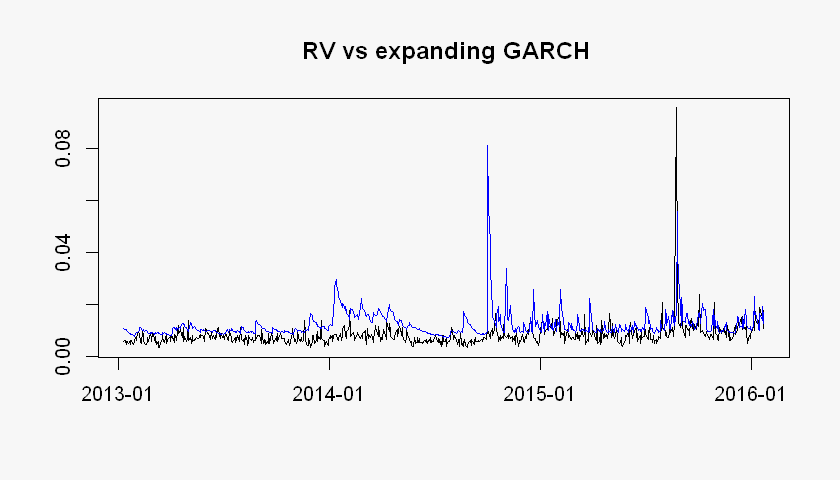

In [71]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 4)

plot.zoo(RV_day[(w_l+2):(w_l+1+n_for)],xlab=NA,
         ylab=NA,format='%Y-%m', main=" RV vs expanding GARCH")
lines(zoo(ARMA_GARCH_exp),col="blue")

* **Compare rolling window with expanding window**

###  (7). Forecast Comparisons

**Because we think the more data have be fit into the regression model, the better the model predicts returns and volatilities. So in model comparision part, we mainly focus on <span style='background: lightblue'> Expanding window</span> forecast results for data analysis.**  
For this part, since all data structures are similar, we store forecast result data of all models into list, and write for-loop to do all analysis at once，as it is not that complicated but also effective.

* **Plot and compare forecast errors**

**Forecast error is the diffferent between realized (true) value and the forecast value, we use absolute error value for evaluation.**

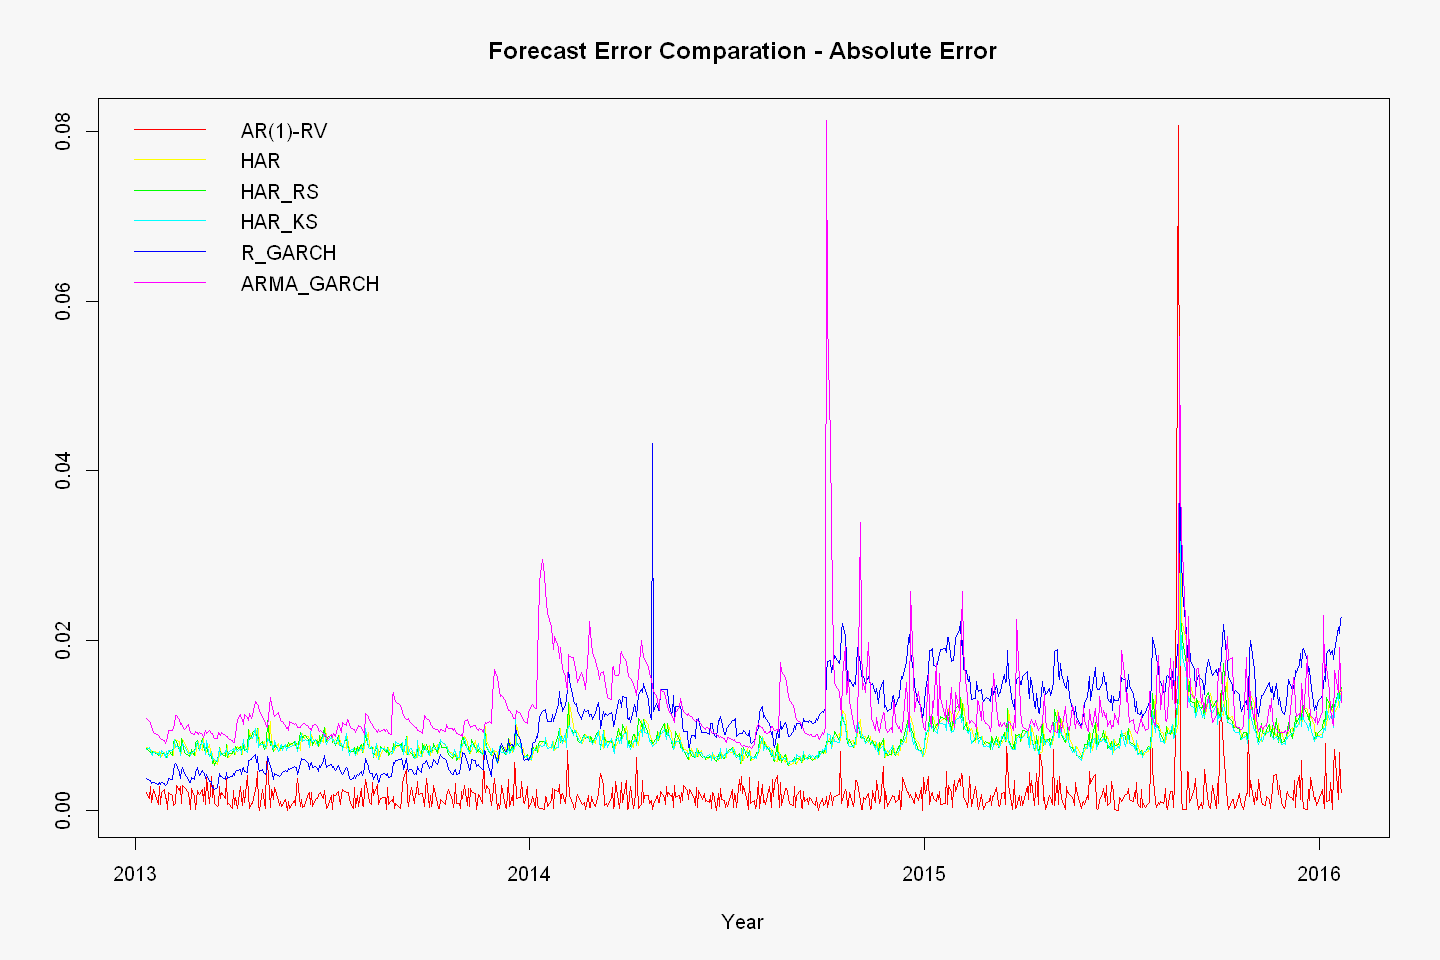

In [72]:
# Create forecast result list for comparation
model_name <- c("AR(1)-RV", "HAR", 'HAR_RS',
    'HAR_KS','R_GARCH',  'ARMA_GARCH' )
for_l <- list(AR1_exp,HAR_exp, HAR_RS_exp, HAR_KS_exp, 
    R_GARCH_exp, ARMA_GARCH_exp)
model_n <- length(for_l)

err_l <- list()
for (i in 1:model_n) {
    # calculate the absolute error
    err_l[[i]] <- abs(RV_day - for_l[[i]])
}
    
r_col <- rainbow(6)
par(bg = "#f7f7f7")
options(repr.plot.width = 12, repr.plot.height = 8)

plot.zoo(err_l[[1]], xlab='Year', ylab=NA, col = r_col[1],
         main= "Forecast Error Comparation - Absolute Error")
for (i in 2:model_n) {
    lines(zoo(for_l[[i]]), col = r_col[i])
}
legend("topleft", legend = model_name, col = r_col, 
       lwd = 1, bty="n")

**By observe the plot, we could see AR(1) model has lowest error values. The second best model is  HAR-RS, its error is higher at begining, but is more stable, and the error is lower for longer period.  
ARMA_GARCH has the highest Error values, then the second worst is R_GARCH model.**

* **Loss functions and Diebold-Mariano test**

**i. Mean Absolute Error(MAE) Evaluation**

In [73]:
#MAE
MAE_loss<-function(proxy,forecast){
  return(abs(proxy-forecast))
}

mae_v <- c()
for (i in 1:model_n) {
    mae_v[i] <- 100 * mean(MAE_loss(RV_day,for_l[[i]]))
}

df_mae <- data.frame(mae_v)
row_n <- model_name
rownames(df_mae) <- row_n
colnames(df_mae) <- 'MAE'
df_mae

,MAE
,<dbl>
AR(1)-RV,0.1892047
HAR,0.1920138
HAR_RS,0.1774133
HAR_KS,0.1817887
R_GARCH,0.4432450
ARMA_GARCH,0.4591863


**For MAE evaluation, HAR-RS model has the least error at 0.17, HAR-KS model at second place at 0.18, and ARMA_GARCH is the worse at 0.45.**

**ii. Mean Square Error(MSE) Evaluation**

In [74]:
#MSE
MSE_loss<-function(proxy,forecast){
  return((proxy-forecast)^2)
}

mse_list <- list()
mse_v <- c()
for (i in 1:model_n) {
    mse_list[[i]] <- MSE_loss(RV_day,for_l[[i]])
    mse_v[i] <- 10000 * mean(mse_list[[i]] )
}

df_mse <- data.frame(mse_v)
row_n <- model_name
rownames(df_mse) <- row_n
colnames(df_mse) <- 'MSE'
df_mse


,MSE
,<dbl>
AR(1)-RV,0.1600025
HAR,0.1611993
HAR_RS,0.1469996
HAR_KS,0.1555220
R_GARCH,0.3499330
ARMA_GARCH,0.5128873


**For MSE evaluation, HAR-RS model has the least error at 0.14, HAR-KS model at second place at 0.15, and ARMA_GARCH is the worse at 0.51.**

* **Diebold-Mariano test**  
(use the MSE loss)

Diebold-Mariano test compares the forecast accuracy of two forecast methods. The null hypothesis is that the two methods have the same forecast accuracy. For alternative=**"two.sided"**, the alternative hypothesis is that method 1 and method 2 have different levels of accuracy.


In [75]:
min_p <- 1
k <- 1
for (i in 1:(model_n-1)) {
    for (j in (i+1):model_n) {
        dm_res <- dm.test(mse_list[[i]],mse_list[[j]],
            alternative = c("two.sided"))
        p_v <- round(dm_res$p.value, 3)
        if (p_v < min_p) { min_p <- p_v }        
        print(paste(k, model_name[i], "vs", model_name[j],":", 
            p_v ))        
        k <- k + 1
    }
}
print(paste("Minimum p-value:", min_p))

[1] "1 AR(1)-RV vs HAR : 0.429"
[1] "2 AR(1)-RV vs HAR_RS : 0.764"
[1] "3 AR(1)-RV vs HAR_KS : 0.507"
[1] "4 AR(1)-RV vs R_GARCH : 0.358"
[1] "5 AR(1)-RV vs ARMA_GARCH : 0.232"
[1] "6 HAR vs HAR_RS : 0.333"
[1] "7 HAR vs HAR_KS : 0.388"
[1] "8 HAR vs R_GARCH : 0.382"
[1] "9 HAR vs ARMA_GARCH : 0.447"
[1] "10 HAR_RS vs HAR_KS : 0.164"
[1] "11 HAR_RS vs R_GARCH : 0.416"
[1] "12 HAR_RS vs ARMA_GARCH : 0.257"
[1] "13 HAR_KS vs R_GARCH : 0.383"
[1] "14 HAR_KS vs ARMA_GARCH : 0.289"
[1] "15 R_GARCH vs ARMA_GARCH : 0.128"
[1] "Minimum p-value: 0.128"


**Because the minimum p-value is 0.13, greater than 0.05, we can not reject the null hypothesis that two methods have same amount of errors. So those methods have similar accuracy, they are as good as each other.**

**If we set the parameter to Greater instead:**  
For alternative="**greater**", the alternative hypothesis is that method 2 is more accurate than method 1.

In [76]:
min_p <- 1
k <- 1

for (i in 1:(model_n-1)) {
    for (j in (i+1):model_n) {
        dm_res <- dm.test(mse_list[[i]],mse_list[[j]],
            alternative = c("greater"))        
        p_v <- round(dm_res$p.value, 3)
        if (p_v < min_p) { min_p <- p_v }        
        print(paste(k, model_name[i], "vs", model_name[j],":", 
            p_v ))        
        k <- k + 1      
    }
}
print(paste("Minimum p-value:", min_p))

[1] "1 AR(1)-RV vs HAR : 0.786"
[1] "2 AR(1)-RV vs HAR_RS : 0.618"
[1] "3 AR(1)-RV vs HAR_KS : 0.746"
[1] "4 AR(1)-RV vs R_GARCH : 0.179"
[1] "5 AR(1)-RV vs ARMA_GARCH : 0.884"
[1] "6 HAR vs HAR_RS : 0.167"
[1] "7 HAR vs HAR_KS : 0.194"
[1] "8 HAR vs R_GARCH : 0.191"
[1] "9 HAR vs ARMA_GARCH : 0.777"
[1] "10 HAR_RS vs HAR_KS : 0.918"
[1] "11 HAR_RS vs R_GARCH : 0.208"
[1] "12 HAR_RS vs ARMA_GARCH : 0.872"
[1] "13 HAR_KS vs R_GARCH : 0.192"
[1] "14 HAR_KS vs ARMA_GARCH : 0.856"
[1] "15 R_GARCH vs ARMA_GARCH : 0.936"
[1] "Minimum p-value: 0.167"


**Still, minimum p-value is 0.167 and it is also not significant enough to reject null hypothesis of two methods have same accuracy, so we could not tell which method is better from Diebold-Mariano test.**

* **Minzer-Zarnowitz regression**

For evaluating forecasting accuracy of model, the quality of the forecast can be measured by the correlation between prediction and realizations.   
By using Minzer-Zarnowitz(MZ) regression to estimate linear regression by RV and forecast volatility, we could tell the presence of systematic over or under predictions. And the R-square is an indicator of the correlation between the realization and the forecast, we could use R-square as one evaluation criterion of the accuracy of the forecast from a specific model.  
**In this project we use RV data as "True Value" of realizations, and still mainly focus on expanding window results.**

**i. AR(1)**

In [77]:
# AR(1)
print(paste("MZ regression for:", model_name[1] ))
MZ_roll<-lm((RV_day[(w_l+2):(w_l+1+n_for)])~ (for_l[[1]]))
summary(MZ_roll)                
MZ_coef<-summary(MZ_roll)$coefficients                
(MZ_coef[2,"Estimate"]-1)/MZ_coef[2,"Std. Error"]

[1] "MZ regression for: AR(1)-RV"



Call:
lm(formula = (RV_day[(w_l + 2):(w_l + 1 + n_for)]) ~ (for_l[[1]]))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.022072 -0.001634 -0.000526  0.001007  0.082863 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0023293  0.0005056   4.607 4.81e-06 ***
for_l[[1]]  0.6997971  0.0569125  12.296  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003926 on 748 degrees of freedom
Multiple R-squared:  0.1681,	Adjusted R-squared:  0.167 
F-statistic: 151.2 on 1 and 748 DF,  p-value: < 2.2e-16


[1] -5.274811

**For AR(1)-RV model, the intercept is 0.0023, beta for AR1 is 0.70, and R-squared at 16.7%**

**ii. HAR**

In [78]:
# HAR
print(paste("MZ regression for:", model_name[2] ))
MZ_roll<-lm((RV_day[(w_l+2):(w_l+1+n_for)])~ (for_l[[2]]))
summary(MZ_roll)                
MZ_coef<-summary(MZ_roll)$coefficients                
(MZ_coef[2,"Estimate"]-1)/MZ_coef[2,"Std. Error"]

[1] "MZ regression for: HAR"



Call:
lm(formula = (RV_day[(w_l + 2):(w_l + 1 + n_for)]) ~ (for_l[[2]]))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.008459 -0.001618 -0.000525  0.000973  0.085941 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0021906  0.0005563   3.938 8.98e-05 ***
for_l[[2]]  0.7343915  0.0646399  11.361  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003976 on 748 degrees of freedom
Multiple R-squared:  0.1472,	Adjusted R-squared:  0.146 
F-statistic: 129.1 on 1 and 748 DF,  p-value: < 2.2e-16


[1] -4.109051

**For HAR model, the intercept is 0.0021, beta for HAR is 0.73, and R-squared at 14.59%.  
We can see beta is improved, but R-square decreased.**

**iii. HAR-RS**

In [79]:
# HAR-RS
print(paste("MZ regression for:", model_name[3] ))
MZ_roll<-lm((RV_day[(w_l+2):(w_l+1+n_for)])~ (for_l[[3]]))
summary(MZ_roll)                
MZ_coef<-summary(MZ_roll)$coefficients                
(MZ_coef[2,"Estimate"]-1)/MZ_coef[2,"Std. Error"]

[1] "MZ regression for: HAR_RS"



Call:
lm(formula = (RV_day[(w_l + 2):(w_l + 1 + n_for)]) ~ (for_l[[3]]))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.017441 -0.001555 -0.000436  0.000985  0.083049 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0014979  0.0004932   3.037  0.00247 ** 
for_l[[3]]  0.8146024  0.0567377  14.357  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003812 on 748 degrees of freedom
Multiple R-squared:  0.216,	Adjusted R-squared:  0.215 
F-statistic: 206.1 on 1 and 748 DF,  p-value: < 2.2e-16


[1] -3.267623

**For HAR-RS model, the intercept is 0.0015, beta for HAR_RS at 0.81, and R-squared at 21.48%.  
We can see R-squared gets higher than HAR model.**

**iv. HAR-Rskew-RKurt**

In [80]:
# HAR-KS
print(paste("MZ regression for:", model_name[4] ))
MZ_roll<-lm((RV_day[(w_l+2):(w_l+1+n_for)])~ (for_l[[4]]))
summary(MZ_roll)                
MZ_coef<-summary(MZ_roll)$coefficients                
(MZ_coef[2,"Estimate"]-1)/MZ_coef[2,"Std. Error"]

[1] "MZ regression for: HAR_KS"



Call:
lm(formula = (RV_day[(w_l + 2):(w_l + 1 + n_for)]) ~ (for_l[[4]]))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.020624 -0.001639 -0.000556  0.000926  0.083491 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0021049  0.0005072    4.15 3.71e-05 ***
for_l[[4]]  0.7639345  0.0601077   12.71  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003904 on 748 degrees of freedom
Multiple R-squared:  0.1776,	Adjusted R-squared:  0.1765 
F-statistic: 161.5 on 1 and 748 DF,  p-value: < 2.2e-16


[1] -3.927371

**For HAR-Rskew-RKurt model, the intercept is 0.0021, beta for HAR_KS at 0.76, and R-squared at 17.64%.  
So HAR-KS is better than HAR model but worse than HAR-RS.**

**v. Realized GARCH**

In [81]:
# Realized GARCH
print(paste("MZ regression for:", model_name[5] ))
MZ_roll<-lm((RV_day[(w_l+2):(w_l+1+n_for)])~ (for_l[[5]]))
summary(MZ_roll)                
MZ_coef<-summary(MZ_roll)$coefficients                
(MZ_coef[2,"Estimate"]-1)/MZ_coef[2,"Std. Error"]

[1] "MZ regression for: R_GARCH"



Call:
lm(formula = (RV_day[(w_l + 2):(w_l + 1 + n_for)]) ~ (for_l[[5]]))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.011450 -0.001803 -0.000268  0.001163  0.084306 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0047147  0.0003343   14.10   <2e-16 ***
for_l[[5]]  0.3268590  0.0275640   11.86   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.00395 on 748 degrees of freedom
Multiple R-squared:  0.1582,	Adjusted R-squared:  0.1571 
F-statistic: 140.6 on 1 and 748 DF,  p-value: < 2.2e-16


[1] -24.42103

**For Realized GARCH model, the intercept is 0.0047, beta for R_GARCH at 0.32, and R-squared at 15.6%.  
We can see R-squared is higher than HAR model, consider this model uses return data for forecasting, and the difference of overnight variance information is missing in RV data, it is a not bad result.**

**vi. ARMA-GARCH**

In [82]:
# ARMA-GARCH
print(paste("MZ regression for:", model_name[6] ))
MZ_roll<-lm((RV_day[(w_l+2):(w_l+1+n_for)])~ (for_l[[6]]))
summary(MZ_roll)                
MZ_coef<-summary(MZ_roll)$coefficients                
(MZ_coef[2,"Estimate"]-1)/MZ_coef[2,"Std. Error"]

[1] "MZ regression for: ARMA_GARCH"



Call:
lm(formula = (RV_day[(w_l + 2):(w_l + 1 + n_for)]) ~ (for_l[[6]]))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.010288 -0.001959 -0.000635  0.001113  0.086580 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0060866  0.0003872  15.721  < 2e-16 ***
for_l[[6]]  0.1809141  0.0291713   6.202 9.23e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.004198 on 748 degrees of freedom
Multiple R-squared:  0.04891,	Adjusted R-squared:  0.04763 
F-statistic: 38.46 on 1 and 748 DF,  p-value: 9.231e-10


[1] -28.07851

**For ARMA-GARCH model, the intercept is 0.006, beta for ARMA_GARCH at 0.18, and R-squared at 4.76%.  
We can see this is the worst model in forecast result. Consider GARCH model only uses return data to do forecast, and compare with Realize Volatility data, the close-price to close-price volatility is quite different from open-price to close-price volatility, the difference between prediction and realization would get bigger.**

# Part 4. Summary

###  (1). Sample Data Analysis

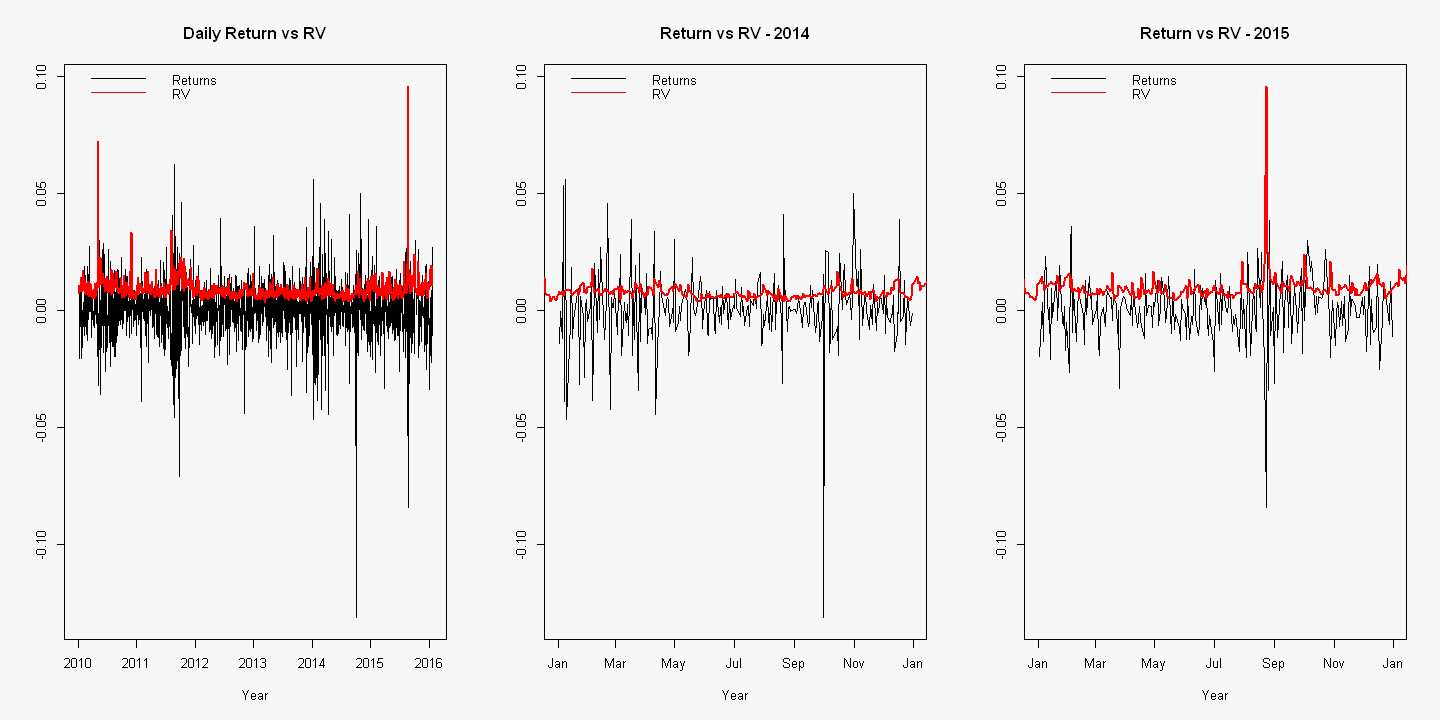

In [83]:
par(bg = "#f7f7f7")
options(repr.plot.width = 12, repr.plot.height = 6)
par(mfrow = c(1, 3))

y_scale <- range(c(rets, RV_day))
plot.zoo(rets, xlab='Year', ylab=NA, main= "Daily Return vs RV",  
         ylim = y_scale)
lines(zoo(RV_day),col="red", lwd=2)
legend("topleft", legend = c("Returns", "RV"), col = c_col2, 
      lwd = 1, bty="n")

d_range <- '2014'
plot.zoo(rets[d_range], xlab='Year', ylab=NA, ylim = y_scale,
         main= "Return vs RV - 2014")
lines(zoo(RV_day),col="red", lwd=2)
legend("topleft", legend = c("Returns", "RV"), col = c_col2, 
      lwd = 1, bty="n")

d_range <- '2015'
plot.zoo(rets[d_range], xlab='Year', ylab=NA, ylim = y_scale,
         main= "Return vs RV - 2015")
lines(zoo(RV_day),col="red", lwd=2)
legend("topleft", legend = c("Returns", "RV"), col = c_col2, 
      lwd = 1, bty="n")

**Most important discovering by compare Return and RV sample data sets, is that they are not exactly matched. Because RV is calculated from Open-Price to Close-Price, so it does not include overnight volatility data. So the spike in Return at 2014-10-01 is not reflected in RV data.**

###  (2). Forecast Schemes Comparison

* **Compare rolling window with expanding window schemes**  
Rolling window forecasts allow the model to adjust the forecast to accommodate recent changes or trends, meaning it is able to respond better to time-sensitive data.

**Here we use two examples of Rolling window and Expending window forecast results, from R_GARCH and GARCH model respectively. To show  
1.the result differency between two schemes expands with time;  
2.and the difference in sensitivity of Volatility level changes.**

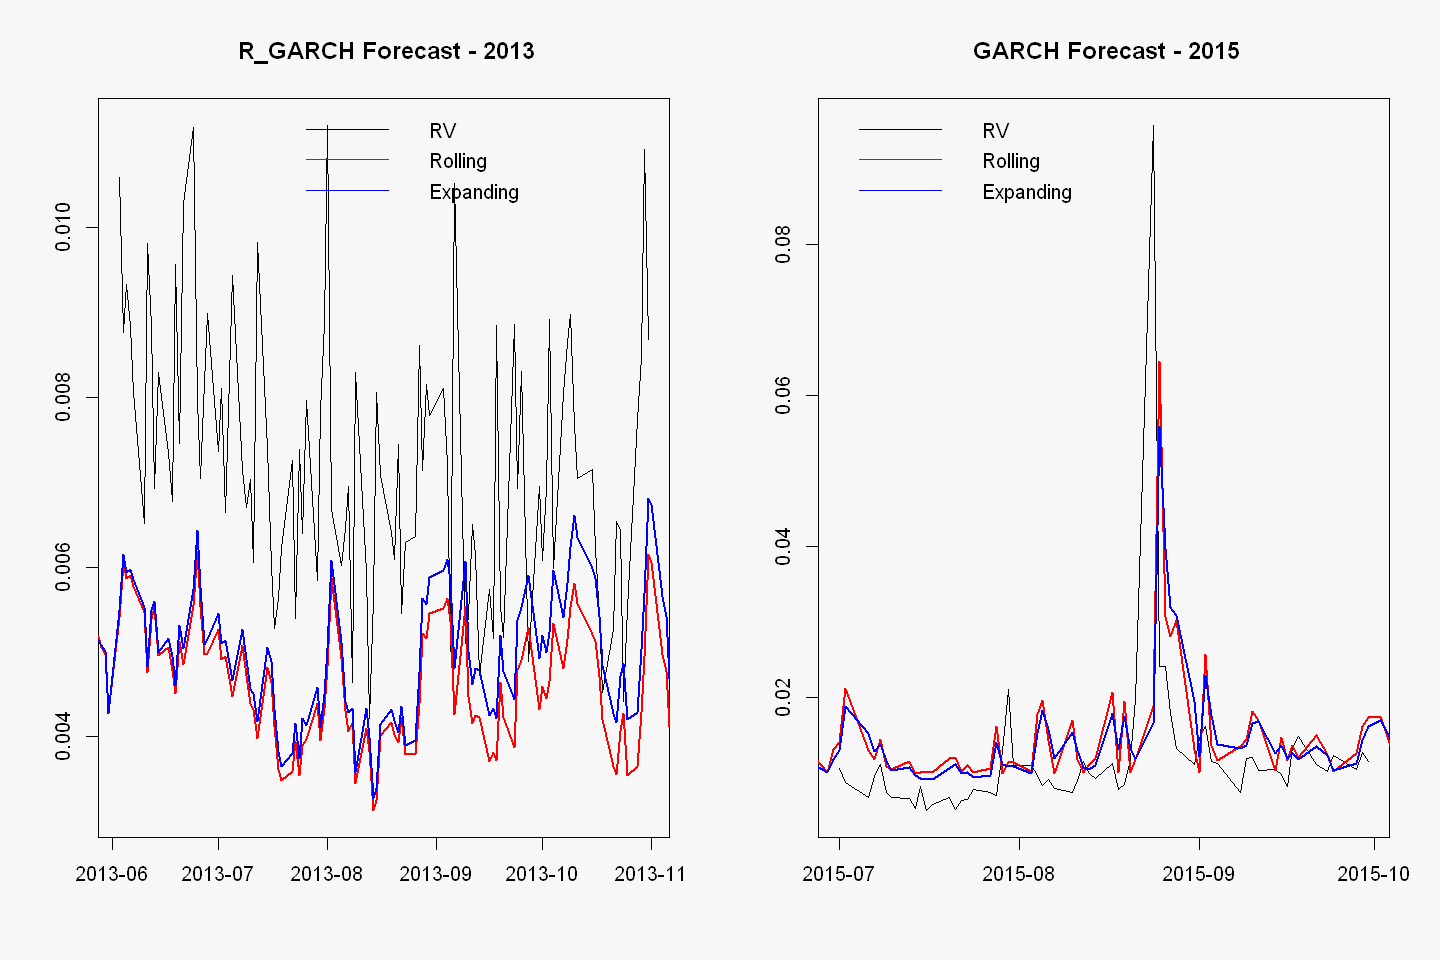

In [84]:
par(bg = "#f7f7f7")
options(repr.plot.width = 12, repr.plot.height = 8)
par(mfrow = c(1, 2))

d_range <- '2013-06/2013-10'
y_scale <- range(c(RV_day[d_range], R_GARCH_roll[d_range]))
plot.zoo(RV_day[d_range],xlab=NA,ylim = y_scale, ylab=NA,
         format='%Y-%m',  main=" R_GARCH Forecast - 2013")
lines(zoo(R_GARCH_roll),col=c_col3[2], lwd=2)
lines(zoo(R_GARCH_exp),col=c_col3[3], lwd=2)
legend("topright", legend = c("RV", "Rolling", "Expanding"), 
       col = c_col3,  lwd = 1, bty="n")


d_range <- '2015-07/2015-09'
plot.zoo(RV_day[d_range],xlab=NA, ylab=NA,format='%Y-%m', 
         main=" GARCH Forecast - 2015")
lines(zoo(ARMA_GARCH_roll),col=c_col3[2], lwd=2)
lines(zoo(ARMA_GARCH_exp),col=c_col3[3], lwd=2)
legend("topleft", legend = c("RV", "Rolling", "Expanding"), 
       col = c_col3,   lwd = 1, bty="n")


**The Rolling window method makes use of fixed windows of data to re-estimate the parameters over the out-of-sample period, whereas the Expanding window method makes use of an increasing window to re-estimate the models.  
In the first example of Realize GARCH forecast result in 2013, at beginning the results from two models are almost same, because at start they both use 750 window size. But later, expanding model has bigger and bigger window size, so the results start to get more and more different at later time period.  
For the scecond example of GARCH forecast result in 2015, by comparation it clearly shows that after the volatility spike, Rolling window forecast adjust the volatility back to normal level faster than Expanding window forecast.**

###  (3). Forecast Results Comparison

**For this part, we choose the forecast period of a volalitity spike happened, then compare the different charactors of models.**

**i. AR(1) vs GARCH**

AR(1): Simple Linear AutoRegressive model;  
GARCH: Captures the Long memory of volatility.

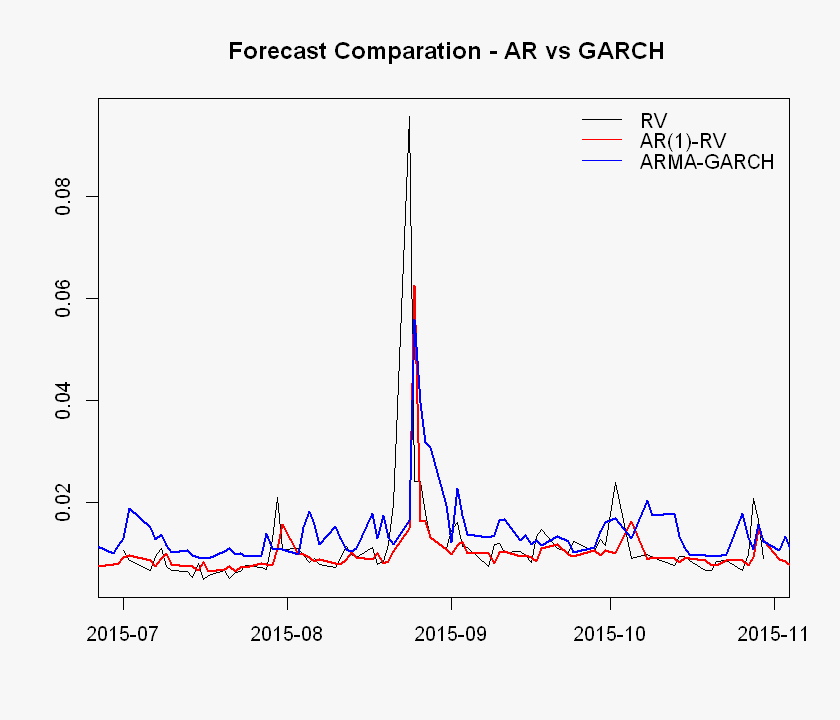

In [85]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)

d_range <- '2015-07/2015-10'
plot.zoo(RV_day[d_range],xlab=NA, ylab=NA,format='%Y-%m', 
         main=" Forecast Comparation - AR vs GARCH")
lines(zoo(AR1_exp),col=c_col3[2], lwd=2)
lines(zoo(ARMA_GARCH_exp),col=c_col3[3], lwd=2)
legend("topright", legend = c("RV", "AR(1)-RV", "ARMA-GARCH" ), 
       col = c_col3, lwd = 1, bty="n")

**From the plot, after the spike GARCH model forecast takes longer time to adjust back to normal volatility level.**

**ii. AR(1) vs HAR**

HAR: Realized measure of High-frequency model, reflects long memory of heterogeneous invesetment horizons of traders.

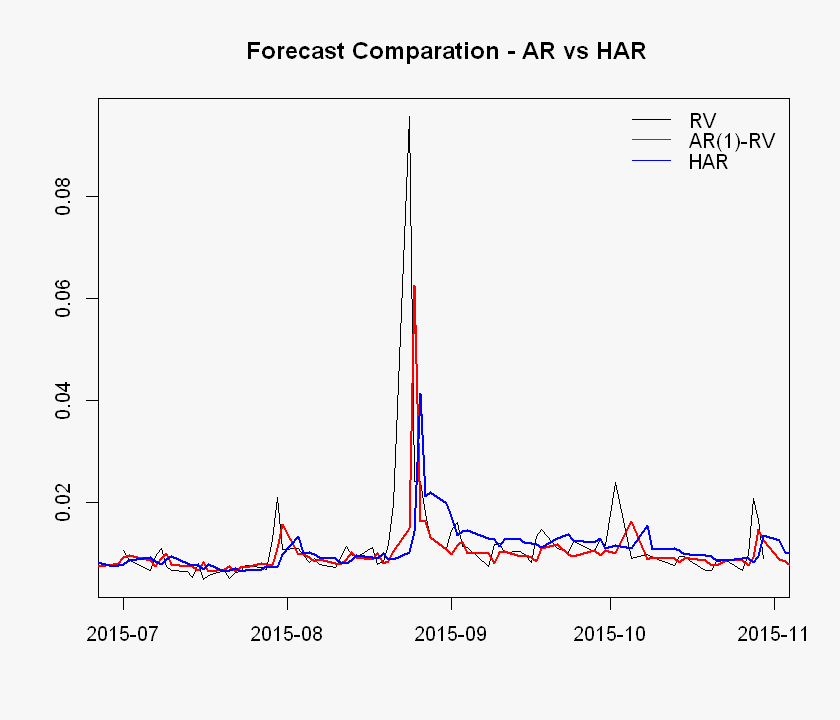

In [86]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)

d_range <- '2015-07/2015-10'
plot.zoo(RV_day[d_range],xlab=NA, ylab=NA,format='%Y-%m', 
         main=" Forecast Comparation - AR vs HAR")
lines(zoo(AR1_exp),col=c_col3[2], lwd=2)
lines(zoo(HAR_exp),col=c_col3[3], lwd=2)
legend("topright", legend = c("RV", "AR(1)-RV", "HAR" ), 
       col = c_col3, lwd = 1, bty="n")

**In HAR forecast, heteragenous investment horizons of traders are applied into the model, so HAR is also approximately a long memory model. So after the spike, HAR forecast take longer time to adjust back to lower volatility level than AR(1) forecast.**

**iii. HAR vs HAR-RS**

HAR-RS: Asymmetry and Realized Semivariance of high-frequency model.

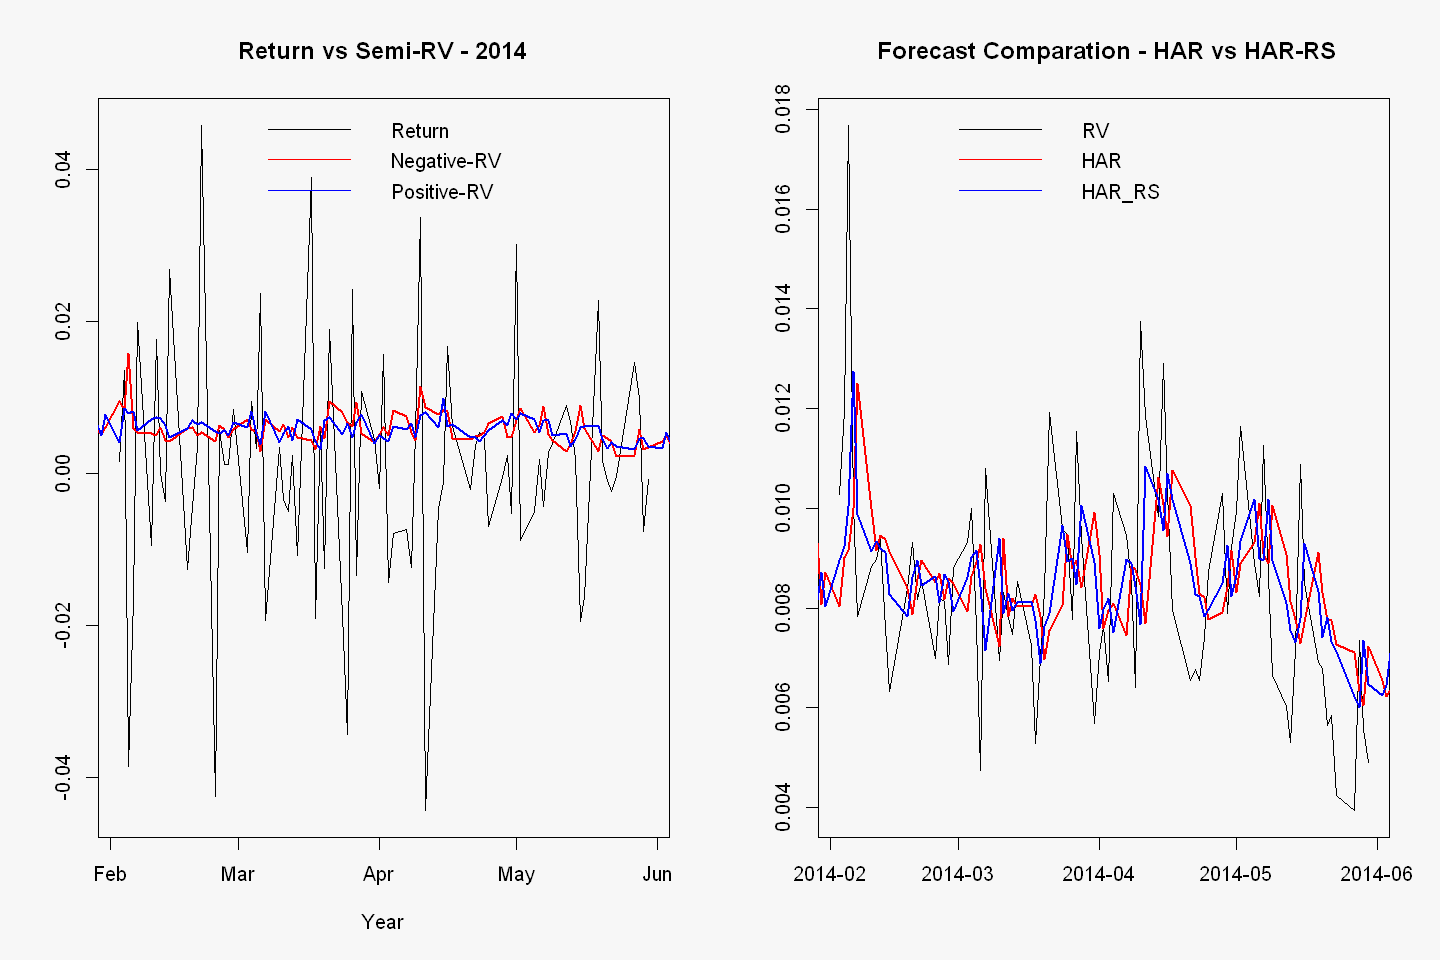

In [87]:
par(bg = "#f7f7f7")
options(repr.plot.width = 12, repr.plot.height = 8)
par(mfrow = c(1, 2))

d_range <- '2014-02/2014-05'

plot.zoo(rets[d_range], xlab='Year', ylab=NA,
    main= "Return vs Semi-RV - 2014")
lines(zoo(RV_n), col = c_col3[2], lwd=2)
lines(zoo(RV_p), col = c_col3[3], lwd=2)
legend("topright", col = c_col3, lwd = 1, bty="n",
      legend = c("Return",  "Negative-RV", "Positive-RV"))

plot.zoo(RV_day[d_range],xlab=NA, ylab=NA,format='%Y-%m', 
         main=" Forecast Comparation - HAR vs HAR-RS")
lines(zoo(HAR_exp),col=c_col3[2], lwd=2)
lines(zoo(HAR_RS_exp),col=c_col3[3], lwd=2)
legend("top", legend = c("RV", "HAR", "HAR_RS" ), 
       col = c_col3, lwd = 1, bty="n")

**During 2014 Spring, there are more negative returns in sample data, and accordingly Negative RV is higher, so we choose this period to compare the forecast result between HAR and HAR-RS.  
From plot, HAR-RS shows better forecast result than HAR, because of Leverage Effect, bad news has bigger influence to future volatility, and HAR-RS could better capture negative volatility information than general HAR.**


**iv. HAR vs GARCH**

Conventional GARCH only take information from returns to adjust value of conditional variance, no high-frequency data, volotility is latent in GARCH.

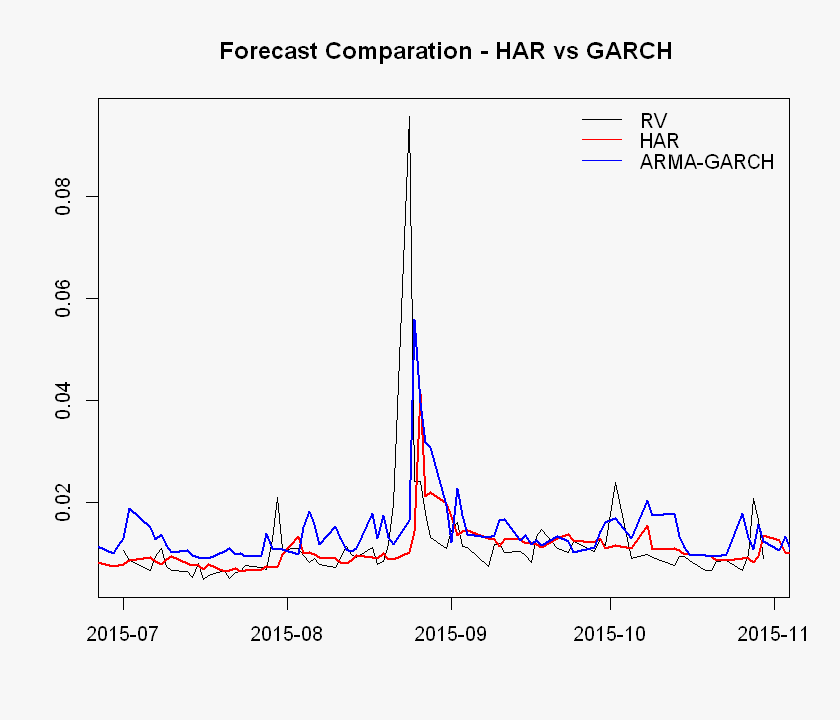

In [88]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)

d_range <- '2015-07/2015-10'
plot.zoo(RV_day[d_range],xlab=NA, ylab=NA,format='%Y-%m', 
         main=" Forecast Comparation - HAR vs GARCH")
lines(zoo(HAR_exp),col=c_col3[2], lwd=2)
lines(zoo(ARMA_GARCH_exp),col=c_col3[3], lwd=2)
legend("topright", legend = c("RV", "HAR", "ARMA-GARCH" ), 
       col = c_col3, lwd = 1, bty="n")

**Becasue CARCH has no volatility data fit in, only assume model estimate the variance parameters. While in HAR model, volatility is ovservable, so it takes longer time for GARCH to adjust to new level of volatility.**

**v. Realized GARCH vs ARMA-GARCH**

Realized GARCH: Joint modeling of returns and realized measures of volatility, a measurement equation that relates the realized measure is added into the conditional variance of returns.

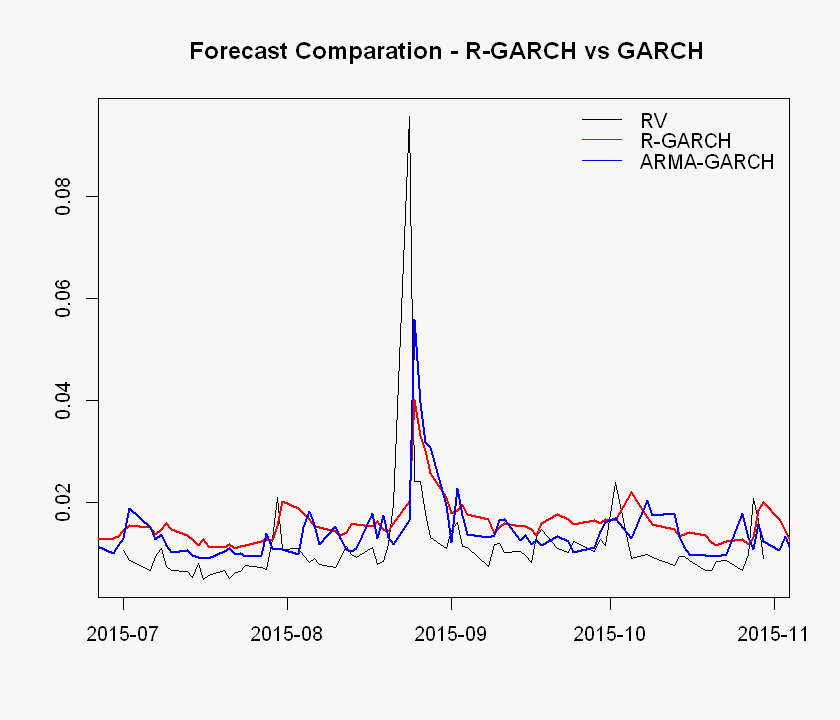

In [89]:
par(bg = "#f7f7f7")
options(repr.plot.width = 7, repr.plot.height = 6)

d_range <- '2015-07/2015-10'
plot.zoo(RV_day[d_range],xlab=NA, ylab=NA,format='%Y-%m', 
         main=" Forecast Comparation - R-GARCH vs GARCH")
lines(zoo(R_GARCH_exp),col=c_col3[2], lwd=2)
lines(zoo(ARMA_GARCH_exp),col=c_col3[3], lwd=2)
legend("topright", legend = c("RV", "R-GARCH", "ARMA-GARCH"), 
       col = c_col3, lwd = 1, bty="n")

**Since in Realized GARCH, realized volatility information is included into Variance component of GARCH:   
$$\ln(h_t)= \omega + \beta ln(h_{t-1})+\gamma ln(RV_{t-1})$$
It helps R-GARCH model to adjust faster for volalitity level changes than normal ARMA GARCH model forecasting. By observing, the forecast result of R-GARCH is better as it adjusts fast after the volatility spike, because R-GARCH model includes realized volatility into GARCH.**

###  (4). Summary

**From above analysis, we reached below findings:**  
* **Sample Data analysis:     
From ACF and PACF test, clearly there are a lot of dependencies in RV samples. All lags are significant, it meets our expectation of Volatility has long memory;  
We also noticed that Return and RV data sets may not exactly matched. Because Realized Variance' defination(normal defination here, assume this project RV is not from MedRV):  
$$RV_T=\sum_{i=1}^{NN} r_i^2$$
so RV(Realized Volatility in this project) data is calculated from intraday Open-Price to Close-Price data, and does not include overnight returns. We need to keep this in mind when use Return sample data related models such as GARCH in forecasting;**
* **In-sample Fit:  
AR(1)-RV has the best in-smaple fit: $$RV_{t+1} = \phi_0 + \phi_1 RV_{t}$$  
ARMA-GARCH seems to be the worst In-sample fit. ARMA-GARCH has the form:  
$$ a_t = \sigma_t \epsilon_t \\
\sigma_t^2 = \alpha_0 + \alpha_1 a_{t - 1}^2 + \beta_1 \sigma_{t - 1}^2$$
So GARCH forecast only based on Return data, instead of RV directly. And as mentioned before, Return and RV those two data set are not exactly matched.**
* **Forecast Schemes:   
Rolling window allows the model to adjust the forecast to accommodate recent changes or trends, meaning it is able to respond better to time-sensitive data. While Expanding window use more data to fit into the regression model, so that to better predicts returns and volatilities.   
Which forecast scheme is better, really depends on the type of the assets and the data set, such as heterogeneity of the data or parameter drifts that can not be easily modeled explicitly;**
* **Out-of-sample Forecast:   
From Loss Function analysis, HAR-RS model predicts the best forcast to match RV data("Ture Value"), especially during the period of more bad news and negative returns. HAR-RS has the form of :  $${RV_t} = \alpha + \beta_1 {RS_{t-1}^+} + \beta_2 {RS_{t-1}^-} + \beta_3 {RV_{t-1}^{(5)}} + \beta_4 {RV_{t-1}^{(22)}} + u_t$$
But because Semi-Variance information are only modelled in t-1 component, which means only captures short-term information, such as Jump. As normal HAR model has form: $${RV_t} = \alpha + \beta_1 {RV_{t-1}} + \beta_2 {RV_{t-1}^{(5)}} + \beta_3 {RV_{t-1}^{(22)}} + u_t,$$
Since those Jump information normally are only small portion of the variance of whole data set(depends on asset type), so the improvement from HAR model is limited.   
ARMA-GARCH again is worst model for out-of-sample forecast, but from the result we see a clear improvement from Rrealized GARCH model. Because R-GARCH has the form:
$$
\begin{align}
r_t= & \sqrt{h_t}z_t \\
ln(h_t)= & \omega + \beta ln(h_{t-1})+\gamma ln(RV_{t-1})\\
ln(RV_t)= & \xi+ \varphi ln(h_t) + u_t
\end{align}
$$
R-GARCH includeds RV information into the variance component of GARCH, helps the model to respond fast for volatility changes. After the spike, RV helps to push down the volatility.**

**For further research in this project, we think it would be interesting to study more on sub-sampling analysis, especially for the period after high spike or parameter shifting.**